In [1]:
import copy

import sklearn.metrics
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from os.path import join as oj
from tqdm import tqdm
import pickle

from imodels.importance import R2FExp, GeneralizedMDI, GeneralizedMDIJoint
from imodels.importance import LassoScorer, RidgeScorer, ElasticNetScorer, RobustScorer, LogisticScorer, JointRidgeScorer, JointLogisticScorer, JointRobustScorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import shap
from feature_importance.scripts.mda import MDA
import sklearn.metrics as metrics

import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme, element_text

In [2]:
DATA_DIR = "../../data"
# RESULTS_DIR = "../../results/tcga_brca"
RESULTS_DIR = "../../results/tcga_brca_normalized"
N_REPS = 10
# FI_MODELS = ["gjmdi_ridge_loocv", "gjmdi_logistic_loocv", "mdi", "perm", "mda"]#, "shap"]
SUBTYPES = ["Basal", "Her2", "LumA", "LumB"]
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR, exist_ok=True)

## Helper Functions

In [3]:
# f1 score for multi-class classification
def multiclass_f1_score(y_onehot, ypreds, sample_weight=None):
    ypreds_label = ypreds.argmax(axis=1)
    y_label = y_onehot.argmax(axis=1)
    results = np.zeros(ypreds.shape[1])
    for k in range(ypreds.shape[1]):
        ypreds_k = (ypreds_label == k).astype(int)
        y_k = (y_label == k).astype(int)
        results[k] = metrics.f1_score(y_k, ypreds_k)
    return results

In [4]:
# helper functions to reformat results
def importance_dict_to_df(d, X_df):
    df = pd.DataFrame(d)
    df["feature"] = X_df.columns
    return df


def class_scores_dict_to_df(d, X_df):
    df_ls = []
    for i, df in enumerate(d.values()):
        df["rep"] = i
        df["feature"] = X_df.columns
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df


def dict_to_df(d, col_id):
    df_ls = []
    for key, df in d.items():
        df[col_id] = key
        df_ls.append(df)
    df = pd.concat(df_ls).reset_index(drop=True)
    return df

In [5]:
# check if in top r
def isin_top_r(x, r=10):
    return x > x.sort_values(ascending=False).values[r]


# count frequency in top r
def top_r_stability(df, r=10):
    drop_features = [col_name for col_name in ["feature", "method"] if col_name in df.columns]
    top_r_df = pd.DataFrame({
        "feature": df["feature"],
        "top_r_stability": df.drop(drop_features, axis=1).
            apply(isin_top_r, axis=0, r=r).mean(axis=1)
    })
    return top_r_df.sort_values("top_r_stability", ascending=False)

## Load in stability analysis results

In [6]:
X_df = pd.read_csv(oj(DATA_DIR, "X_tcga_var_filtered_log_transformed.csv"))

In [15]:
results_dict = {}
for subtype in SUBTYPES:
    results_dict[subtype] = {}
    for rep in range(N_REPS):
        results_fname = oj(RESULTS_DIR, subtype, "rep{}".format(rep), "imp_values_dict.pickle")
        if os.path.exists(results_fname):
            results_rep = pickle.load(open(results_fname, "rb"))
            for method_name, df in results_rep.items():
                if method_name in results_dict[subtype].keys():
                    results_dict[subtype][method_name][rep] = df
                else:
                    results_dict[subtype][method_name] = {rep: df}
    results_dict[subtype] = {method_name: importance_dict_to_df(results, X_df)\
                             for method_name, results in results_dict[subtype].items()}

In [19]:
results_dict["Basal"].keys()

dict_keys(['gjmdi_ridge_loocv', 'gjmdi_logistic_logloss', 'gjmdi_logistic_auprc', 'gjmdi_logistic_auroc', 'gjmdi_logistic_loocv_logloss', 'gjmdi_logistic_loocv_auprc', 'gjmdi_logistic_loocv_auroc'])

In [17]:
results_dict["Basal"]["gjmdi_ridge_loocv"].head()

0             1             2             3             4  \
0  9.103829e-17  1.054712e-16  9.658940e-17  9.880985e-17  1.032507e-16   
1  6.664260e-03  1.138272e-02  2.511763e-03  7.341179e-03  3.319730e-03   
2  9.103829e-17  1.054712e-16  9.658940e-17  9.880985e-17  1.032507e-16   
3  9.103829e-17  1.054712e-16  9.658940e-17  9.880985e-17  1.032507e-16   
4  9.103829e-17  2.077540e-04  9.658940e-17  9.880985e-17  1.032507e-16   

              5             6             7             8             9  \
0  8.770762e-17  1.132427e-16  1.021405e-16  8.437695e-17 -8.629895e-05   
1  1.263859e-02  9.399495e-04  6.173816e-04  6.575149e-03  2.193228e-03   
2  8.770762e-17 -8.033742e-05  1.021405e-16 -3.113096e-05  1.121325e-16   
3 -5.243447e-06  1.132427e-16  1.021405e-16  8.437695e-17  1.121325e-16   
4  8.770762e-17  1.132427e-16  1.021405e-16  8.437695e-17  4.653352e-04   

        feature  
0           A2M  
1          NAT1  
2  RP11.986E7.7  
3          AAMP  
4          AARS

In [23]:
results_dict["Basal"]["gjmdi_logistic_logloss"].head()

0         1         2        3         4         5         6  \
0      -inf      -inf      -inf     -inf      -inf      -inf      -inf   
1  1.412976  0.810567  0.629277  0.87758  0.803984  0.898148  0.577327   
2      -inf      -inf      -inf     -inf      -inf      -inf  1.188432   
3      -inf      -inf      -inf     -inf      -inf  0.502049      -inf   
4      -inf  1.053440      -inf     -inf      -inf      -inf      -inf   

          7         8         9       feature  
0      -inf      -inf  0.815057           A2M  
1  0.631683  1.197597  0.742879          NAT1  
2      -inf  5.531301      -inf  RP11.986E7.7  
3      -inf      -inf      -inf          AAMP  
4      -inf      -inf  1.682040          AARS

In [20]:
results_dict["Basal"]["gjmdi_logistic_loocv_logloss"].head()

0         1         2         3         4         5         6  \
0      -inf      -inf      -inf      -inf      -inf      -inf      -inf   
1  0.611261  0.549266  0.713906  0.471336  0.657381  0.602705  0.585770   
2      -inf      -inf      -inf      -inf      -inf      -inf  0.859102   
3      -inf      -inf      -inf      -inf      -inf  0.822112      -inf   
4      -inf  0.847728      -inf      -inf      -inf      -inf      -inf   

          7         8         9       feature  
0      -inf      -inf  1.052157           A2M  
1  0.723867  0.648550  0.664420          NAT1  
2      -inf  0.762175      -inf  RP11.986E7.7  
3      -inf      -inf      -inf          AAMP  
4      -inf      -inf  0.797609          AARS

## Visualize stability results

Check stability in top 10

In [21]:
stability_dict = {
    subtype: {
        method_name: top_r_stability(df, r=10) for method_name, df in results_dict[subtype].items()
    } for subtype in results_dict.keys()
}

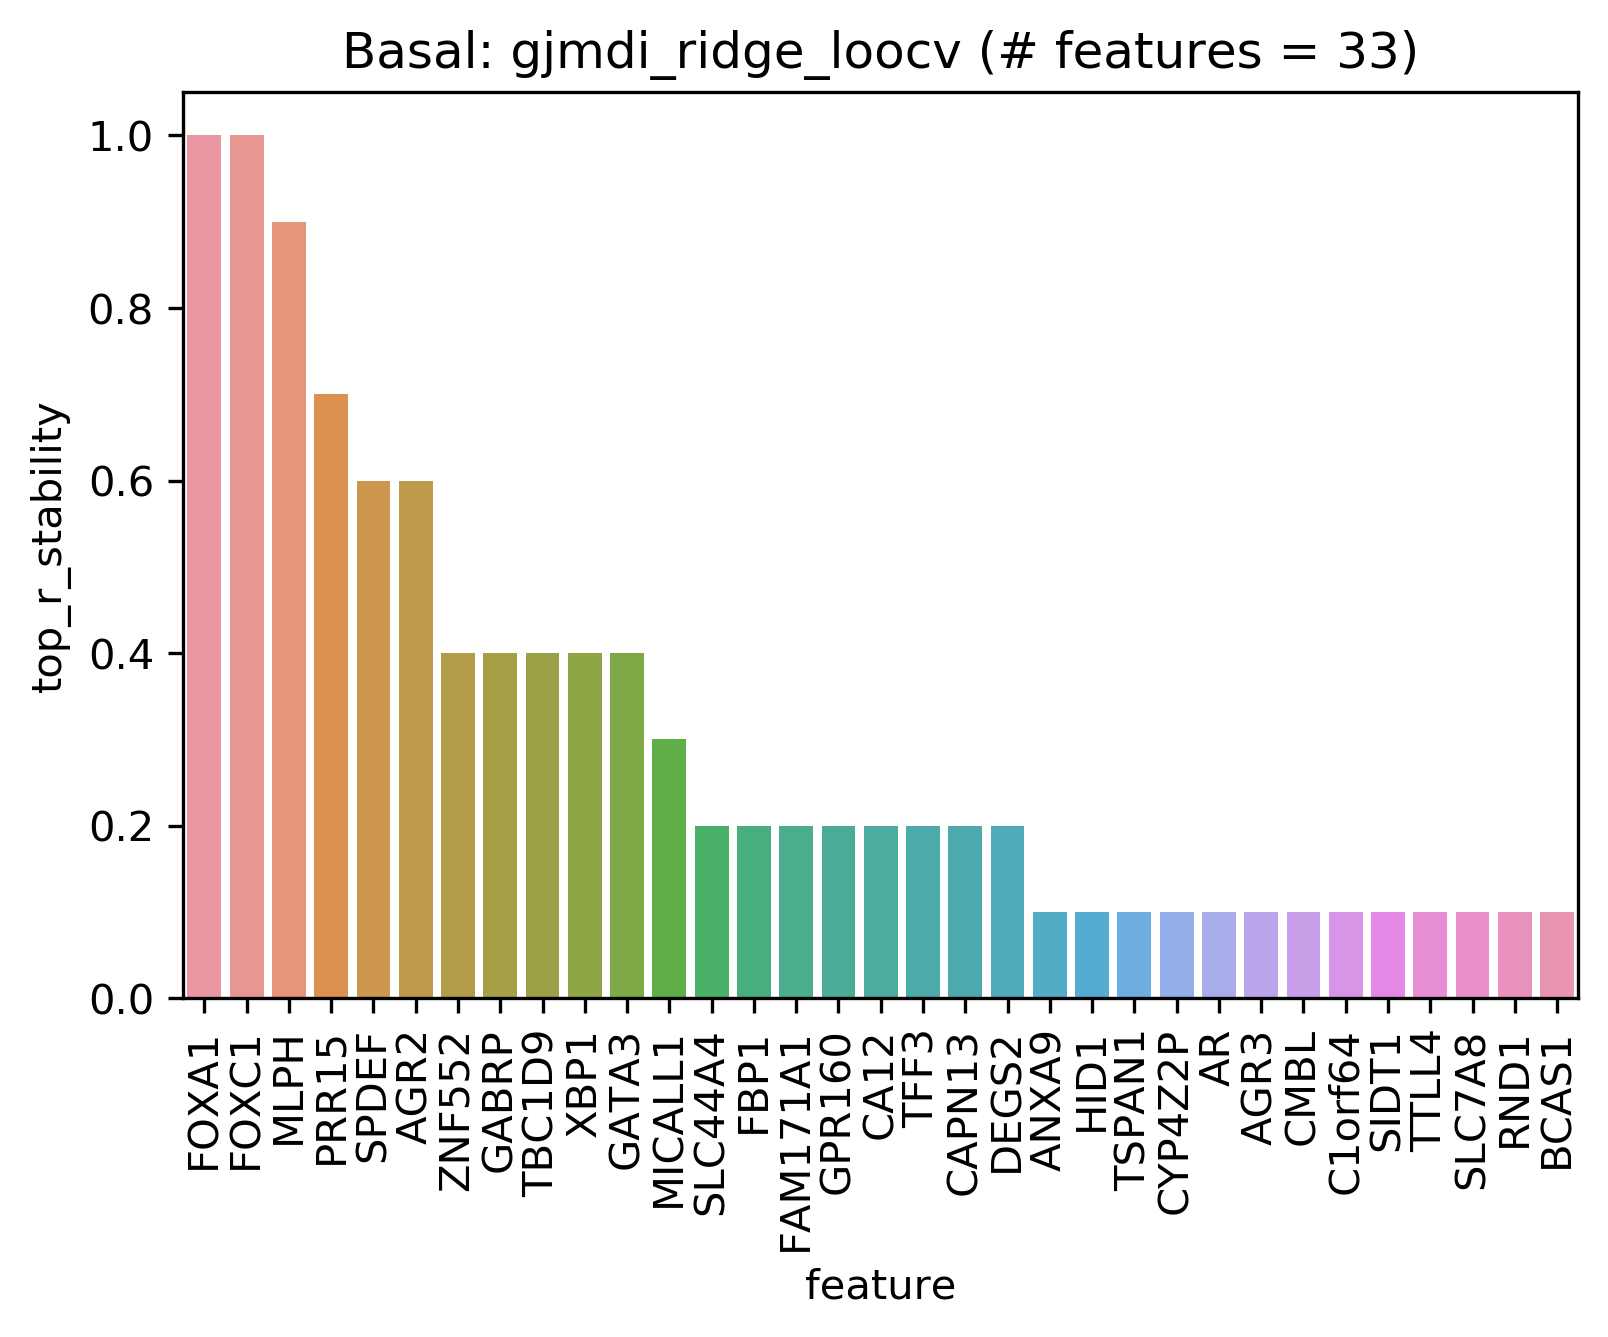

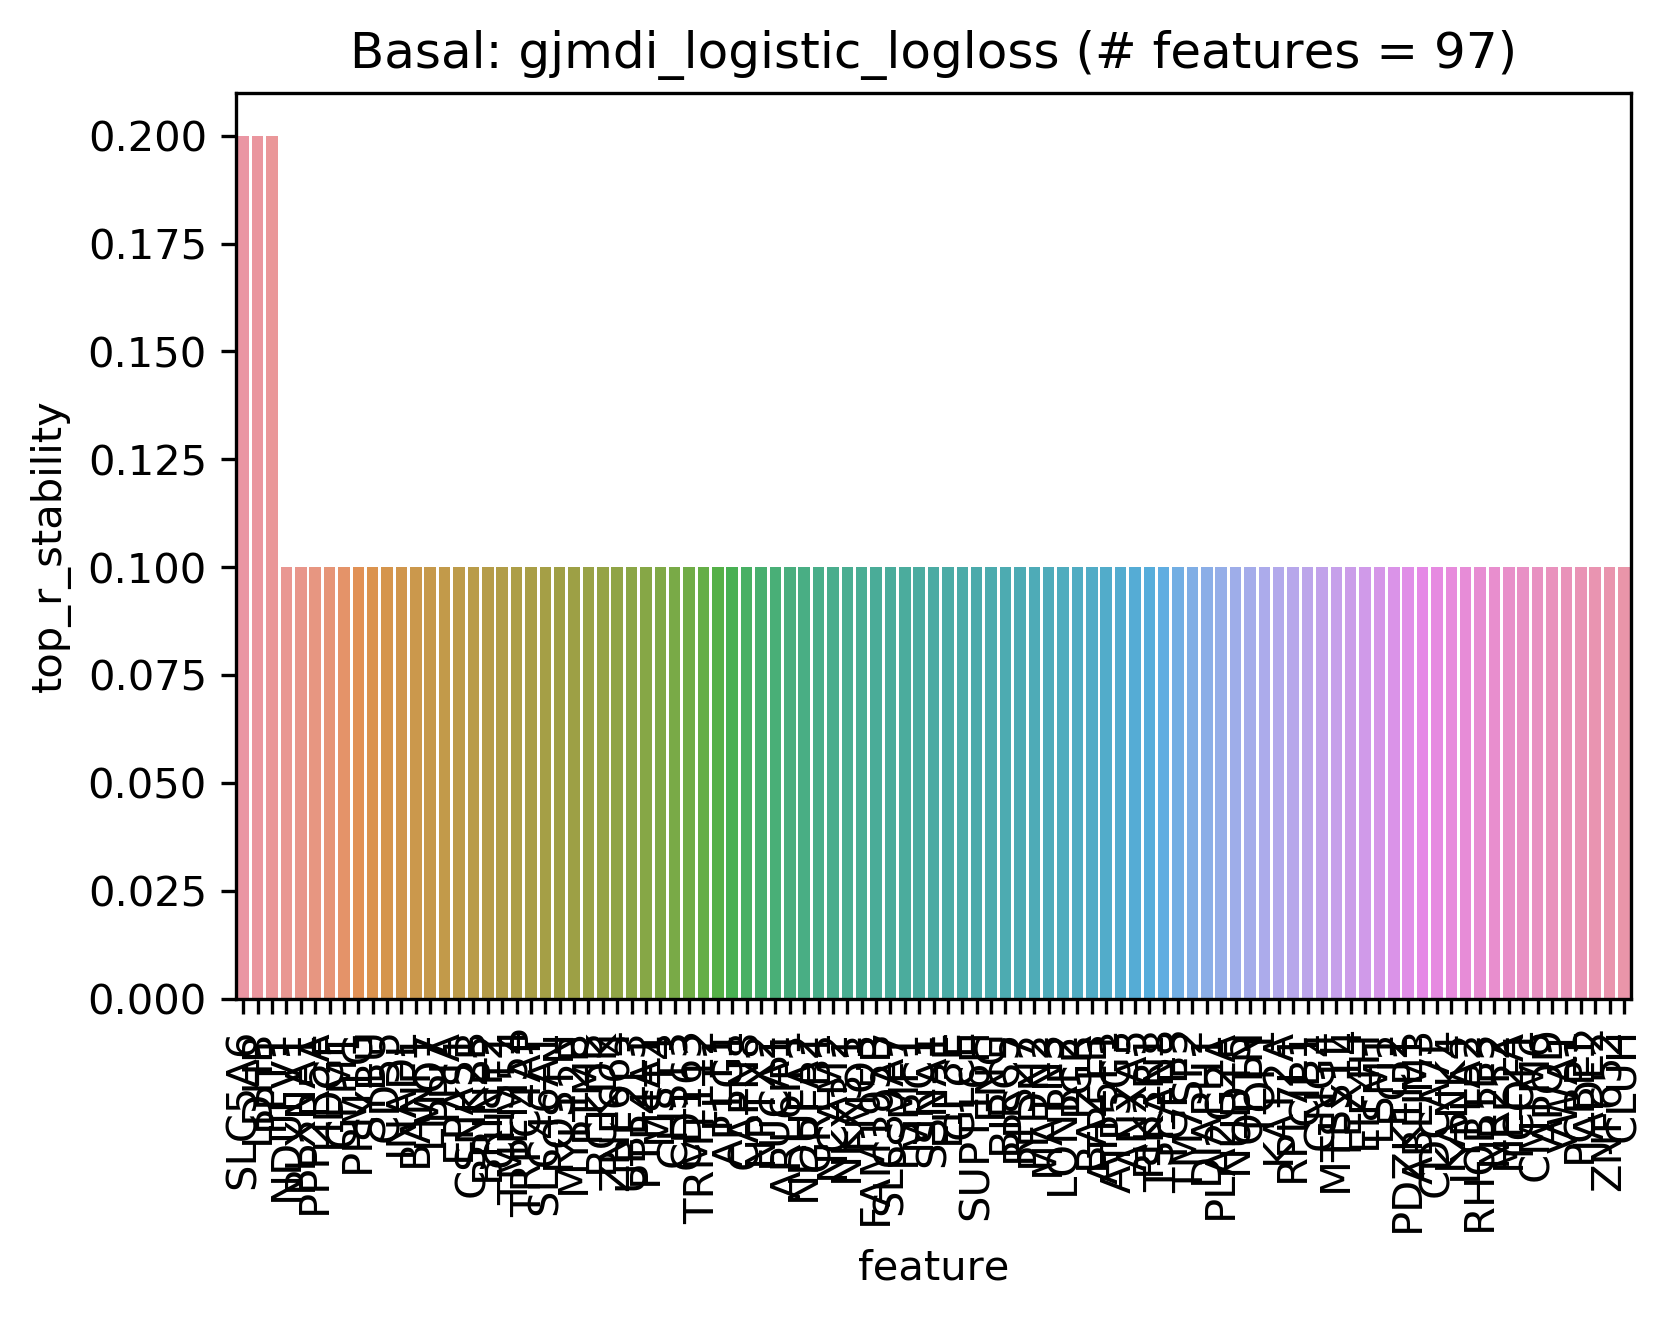

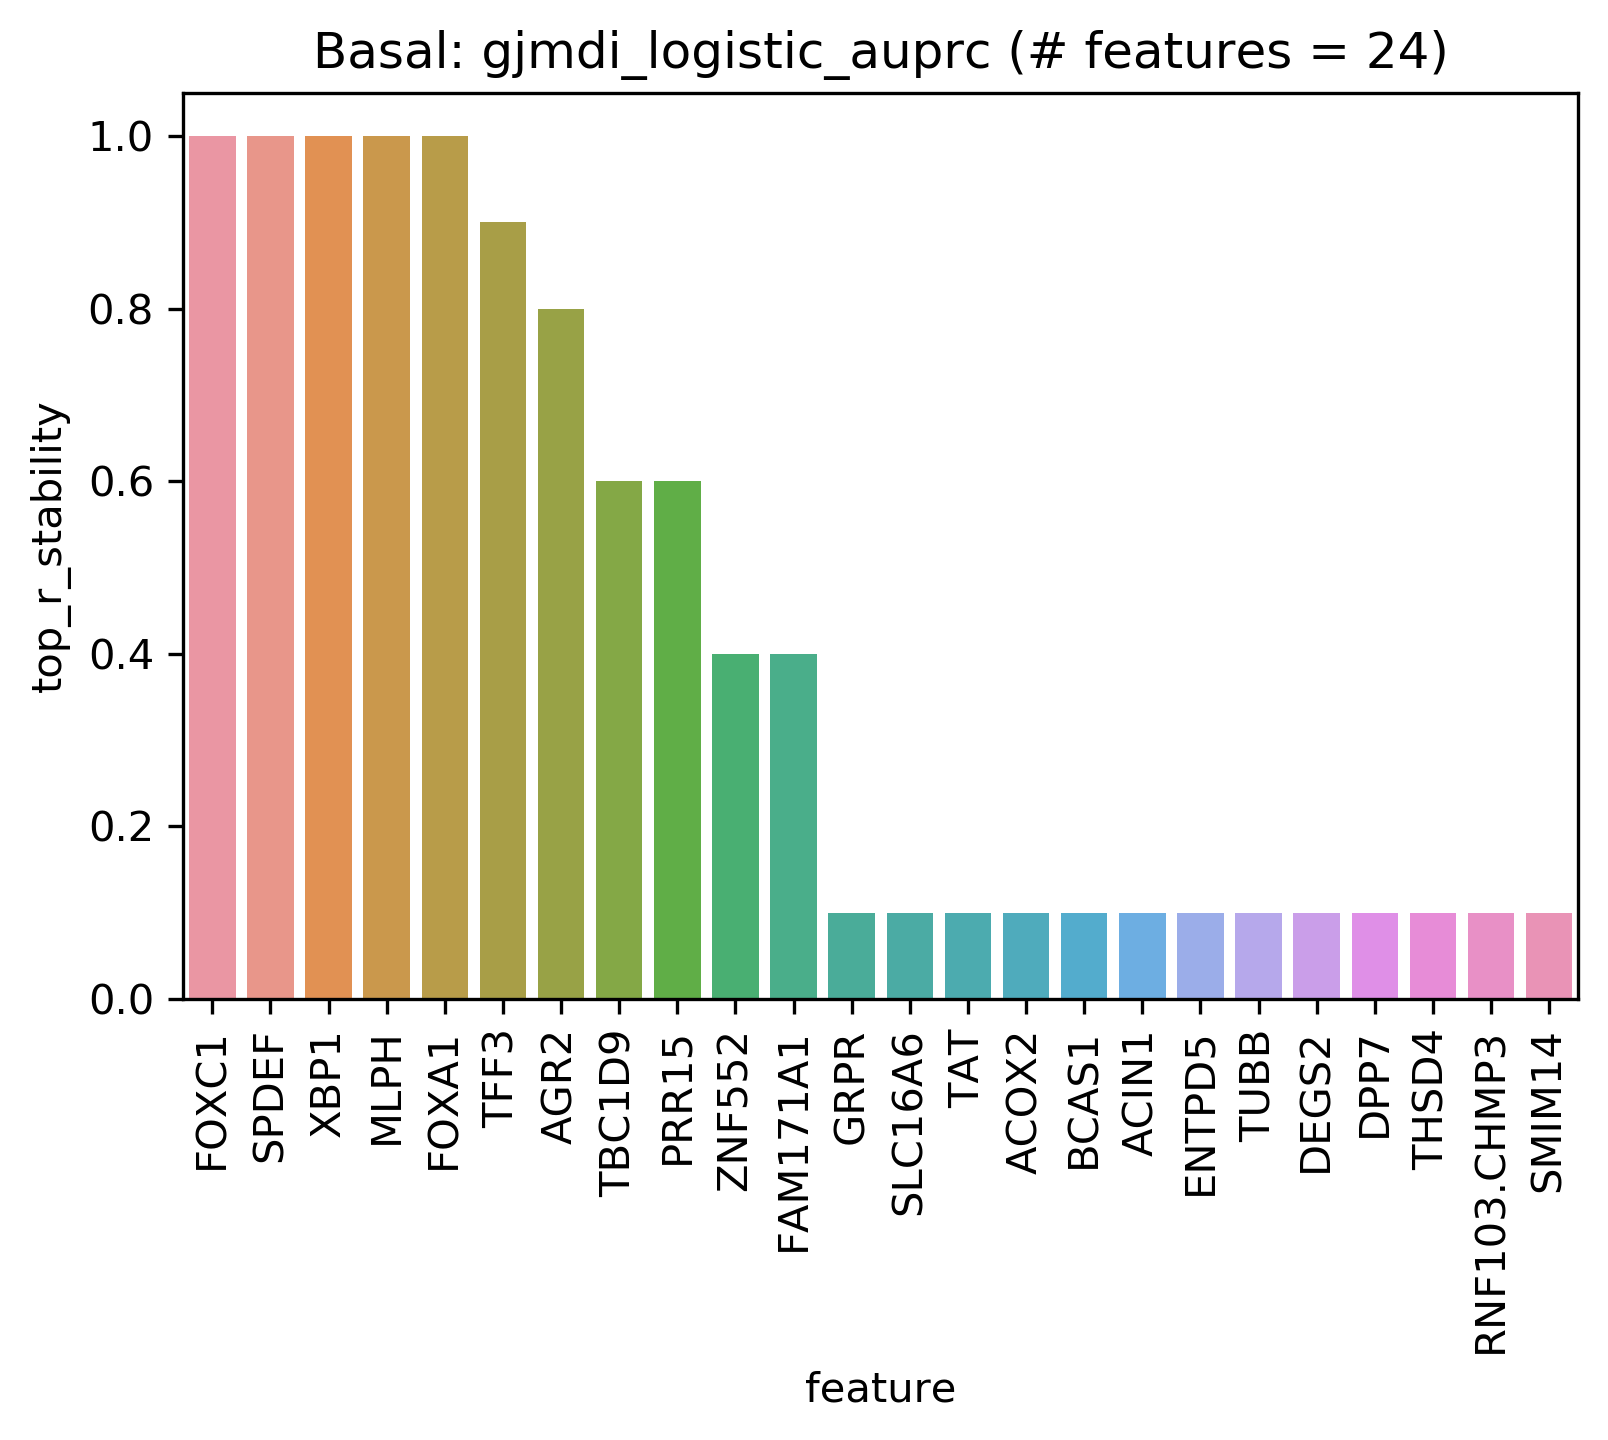

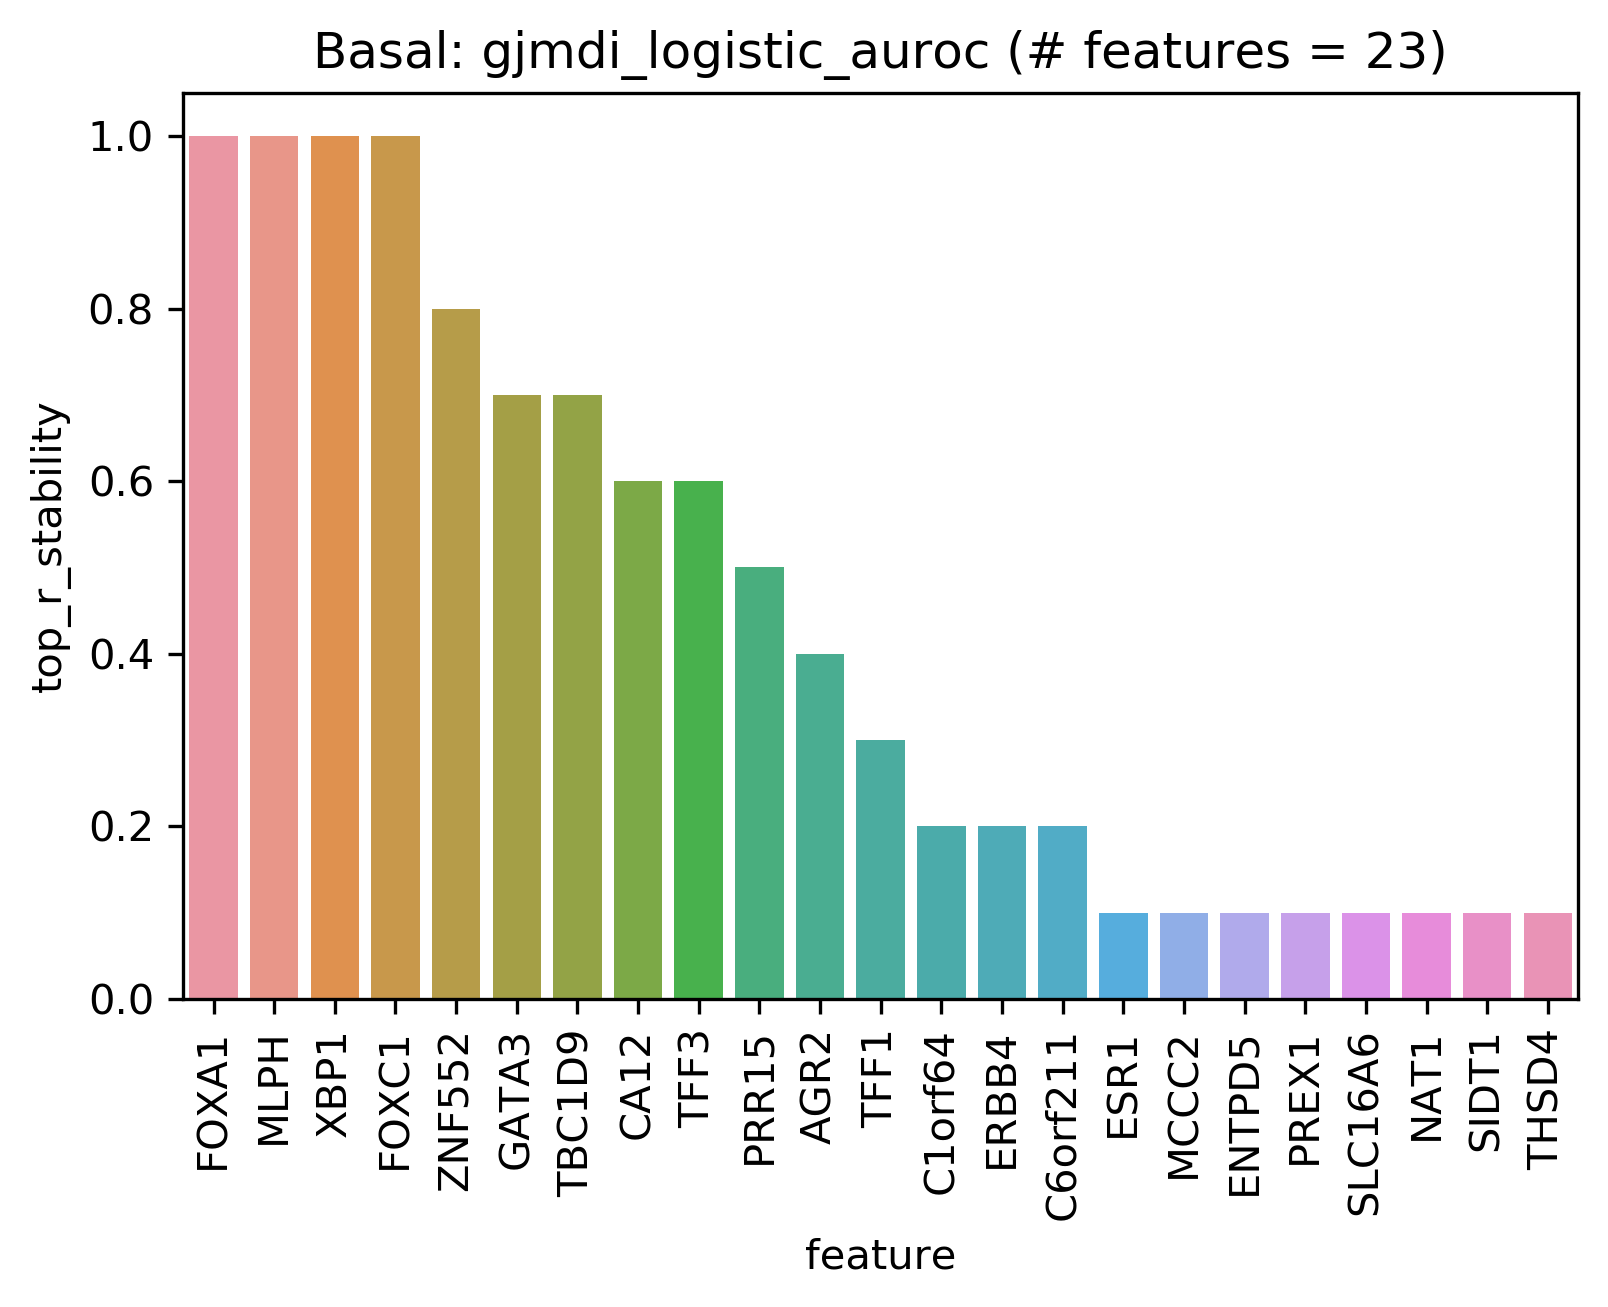

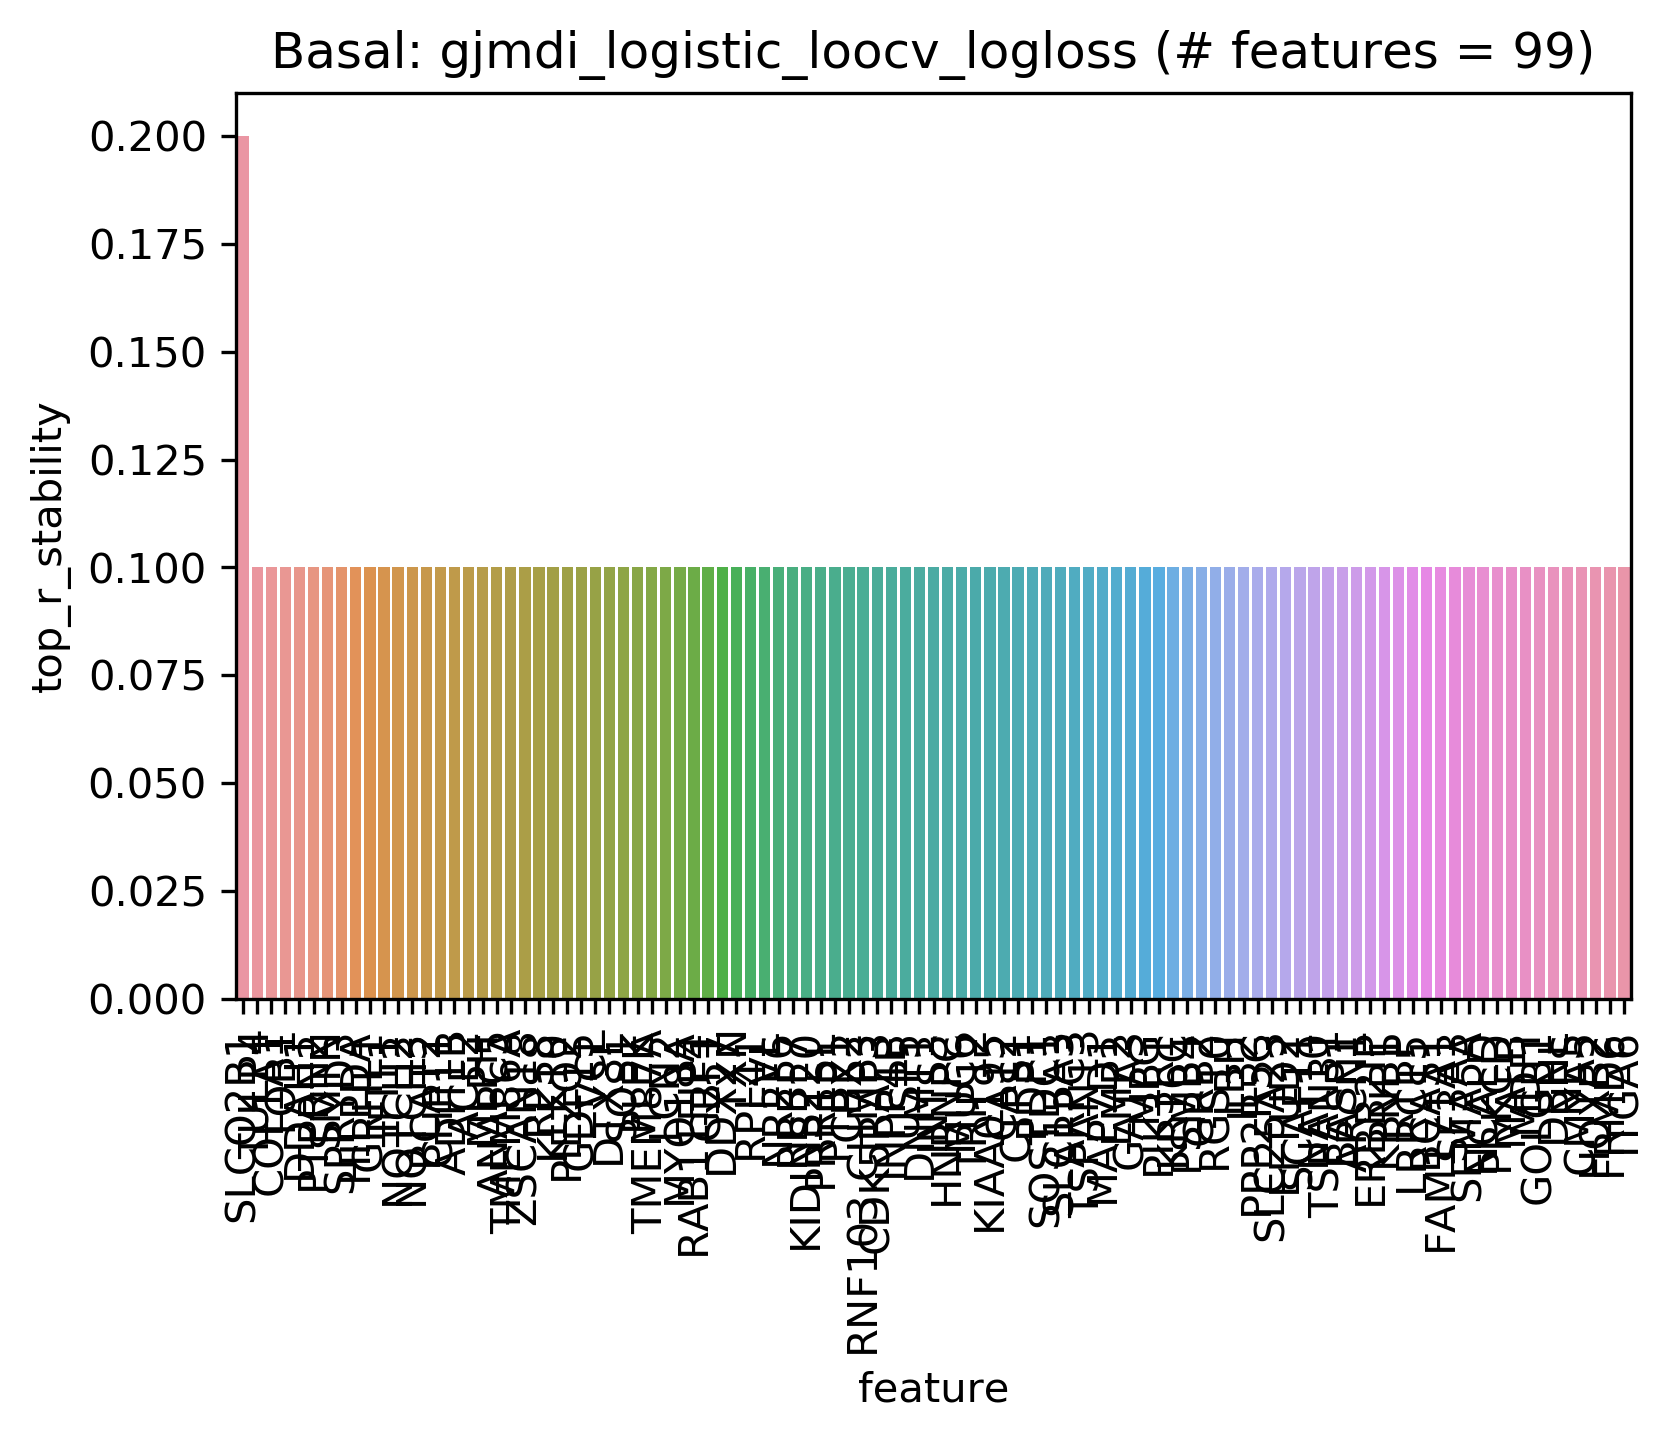

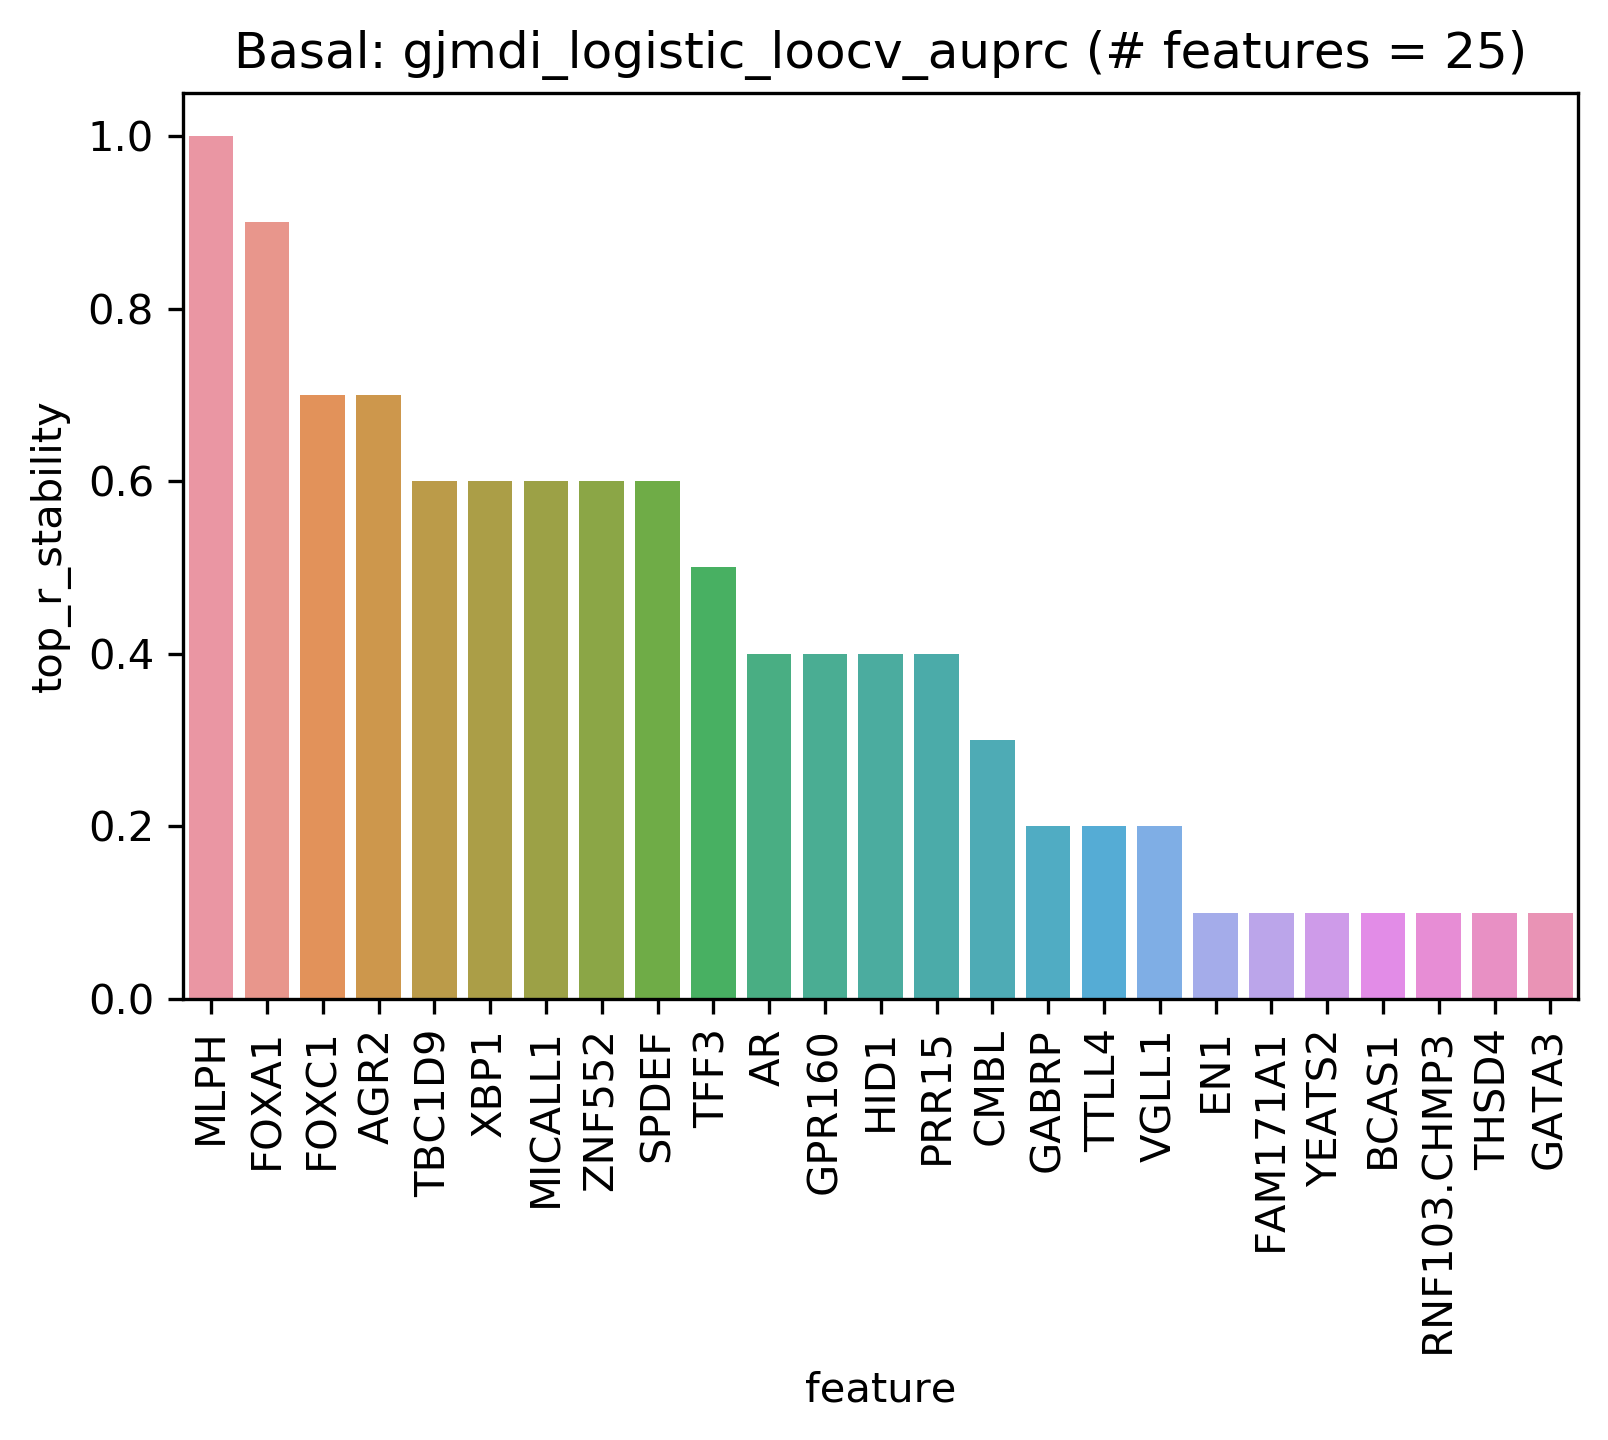

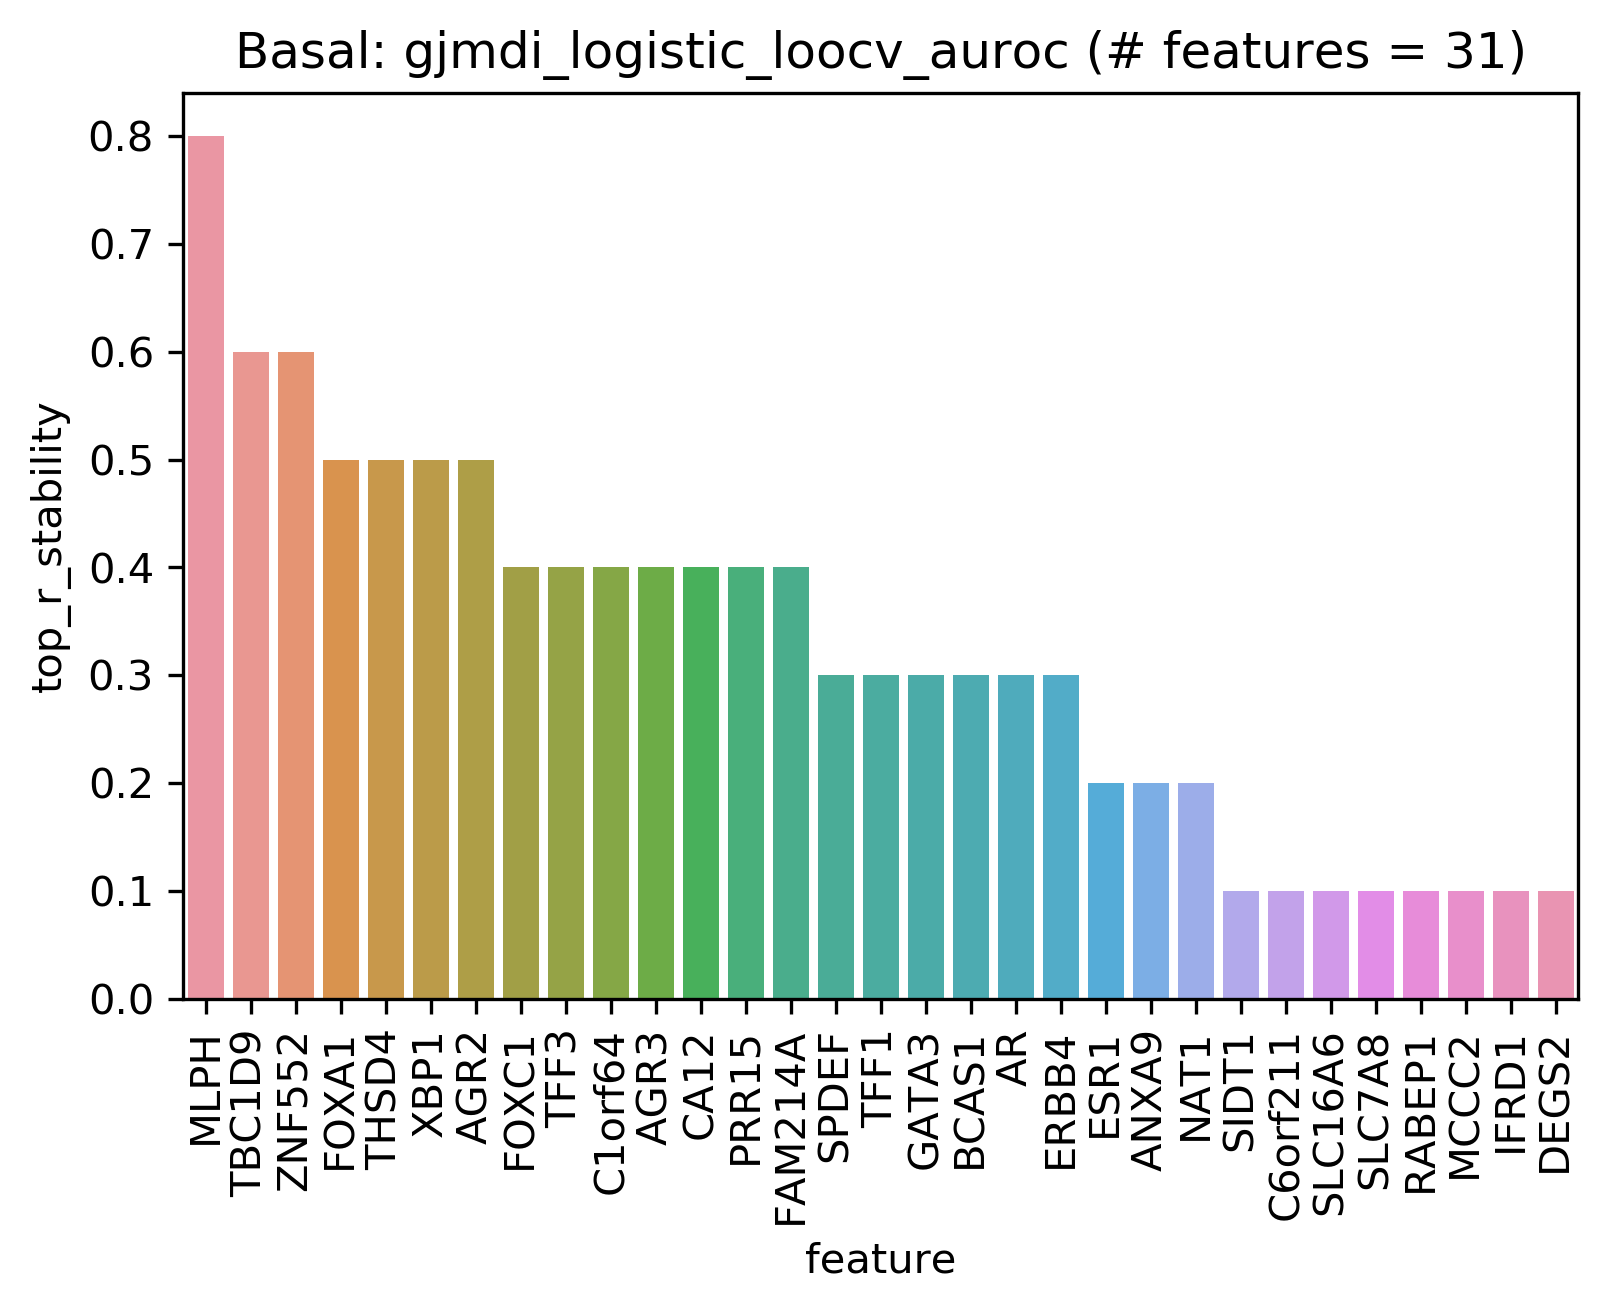

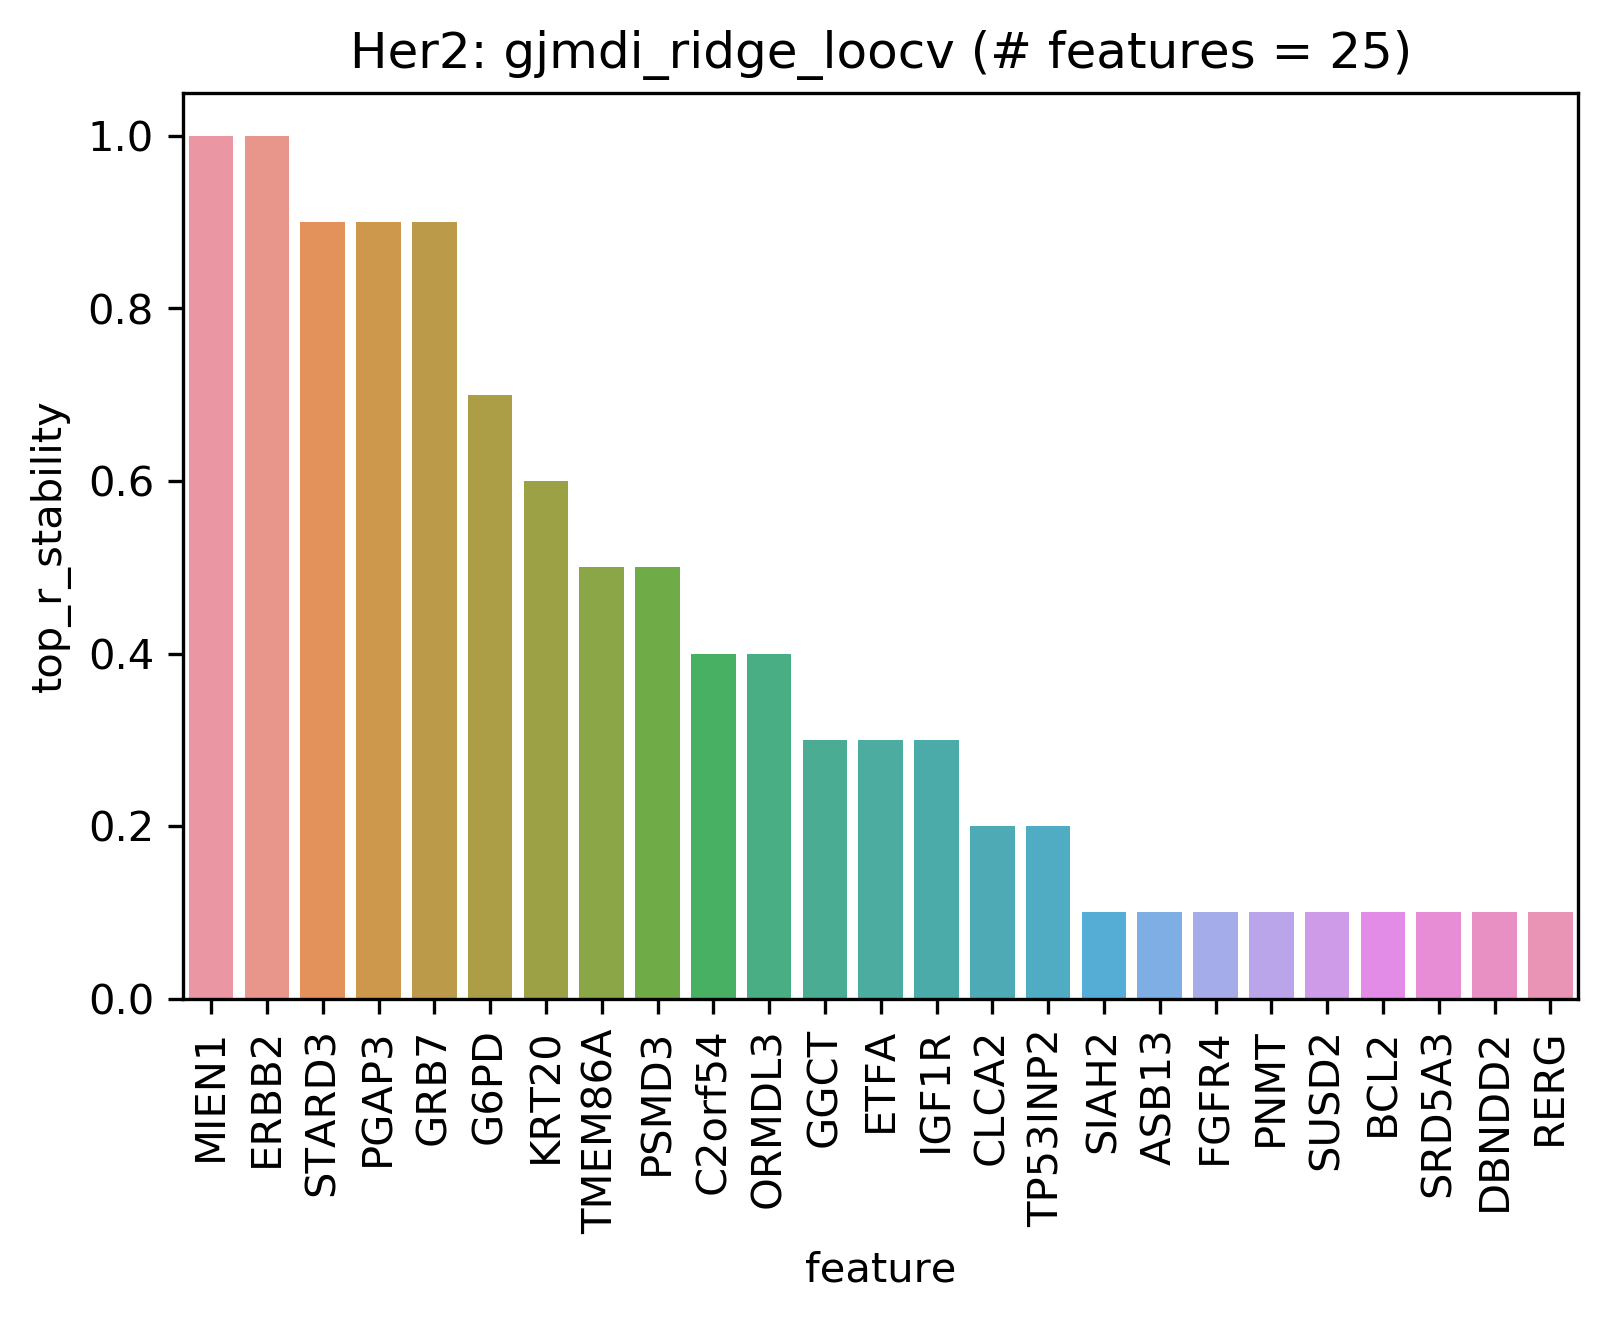

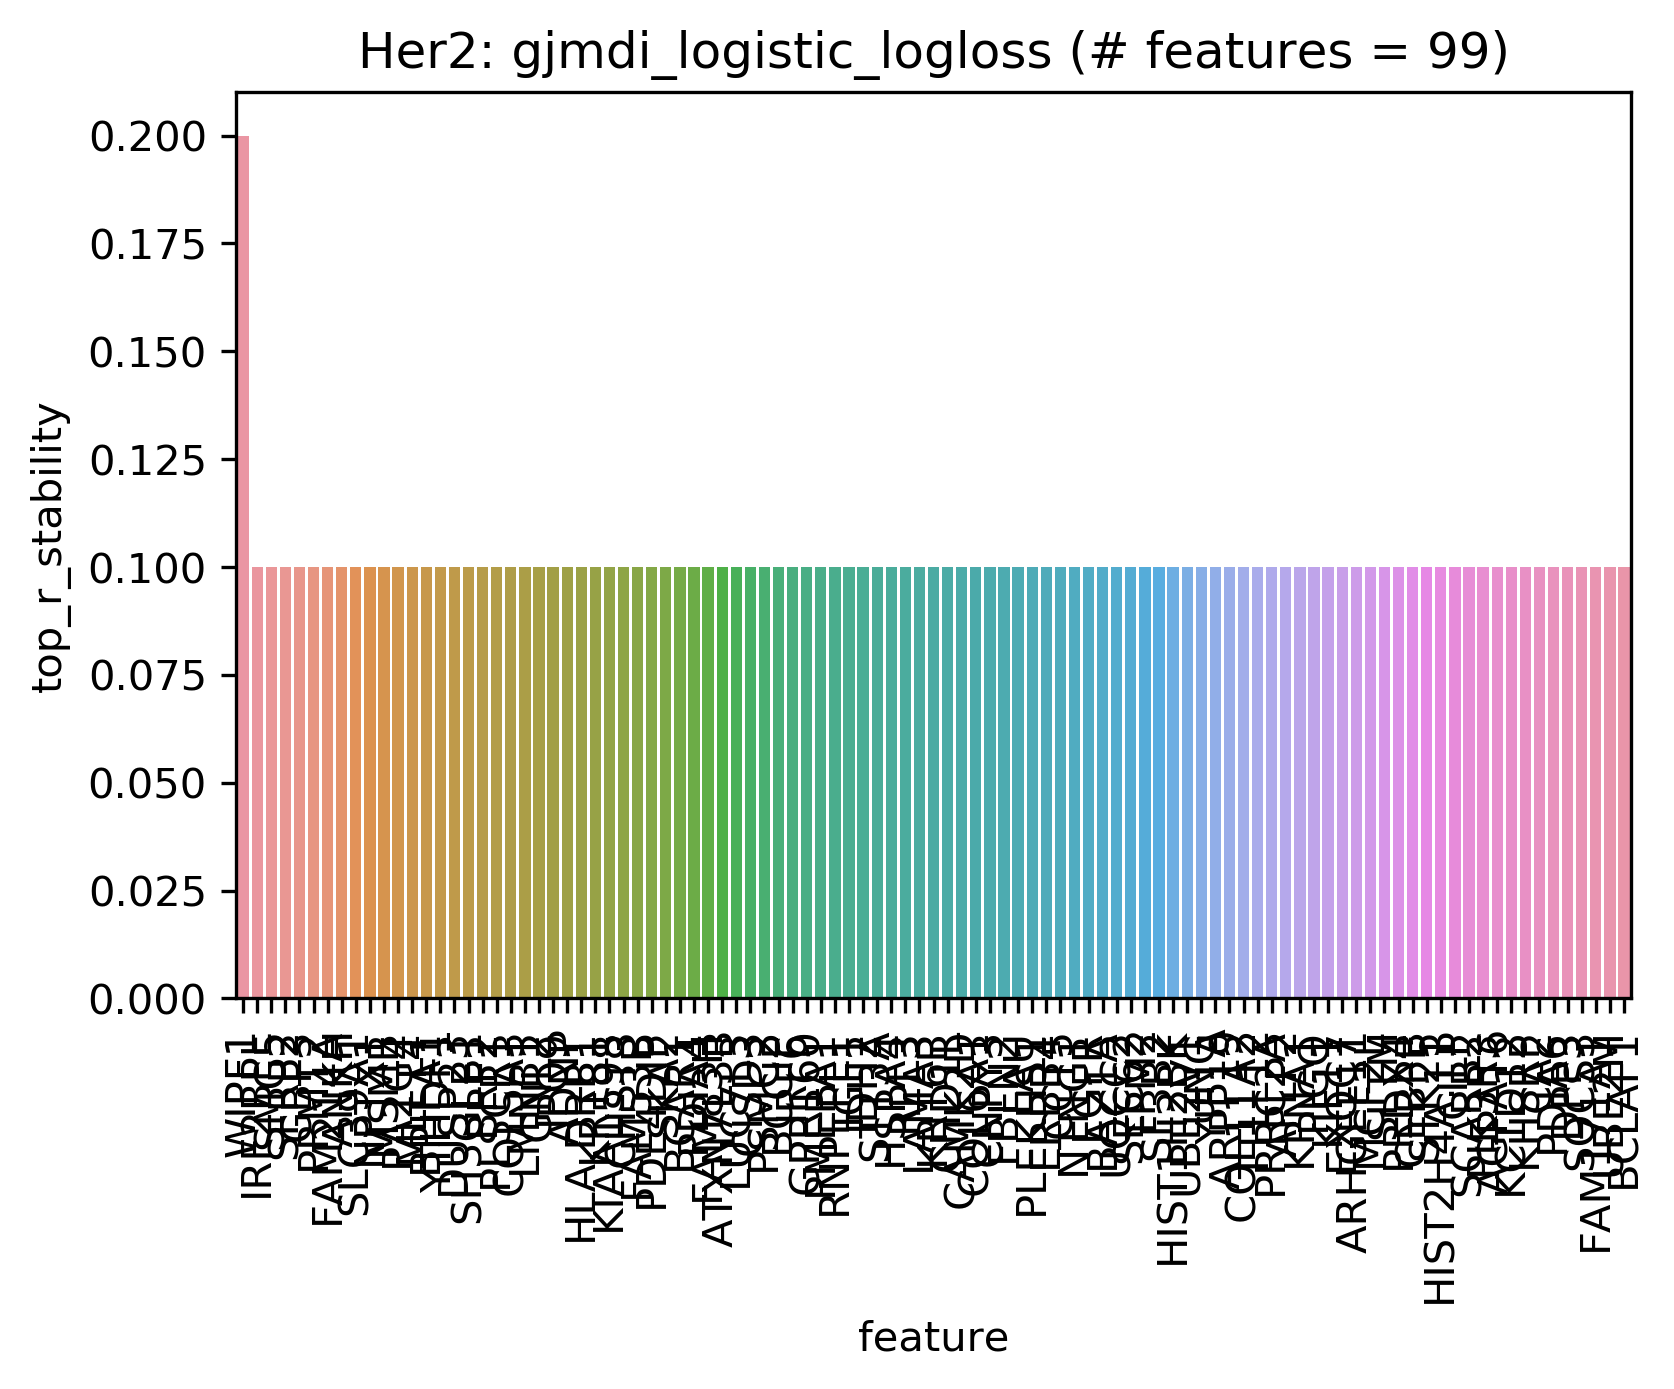

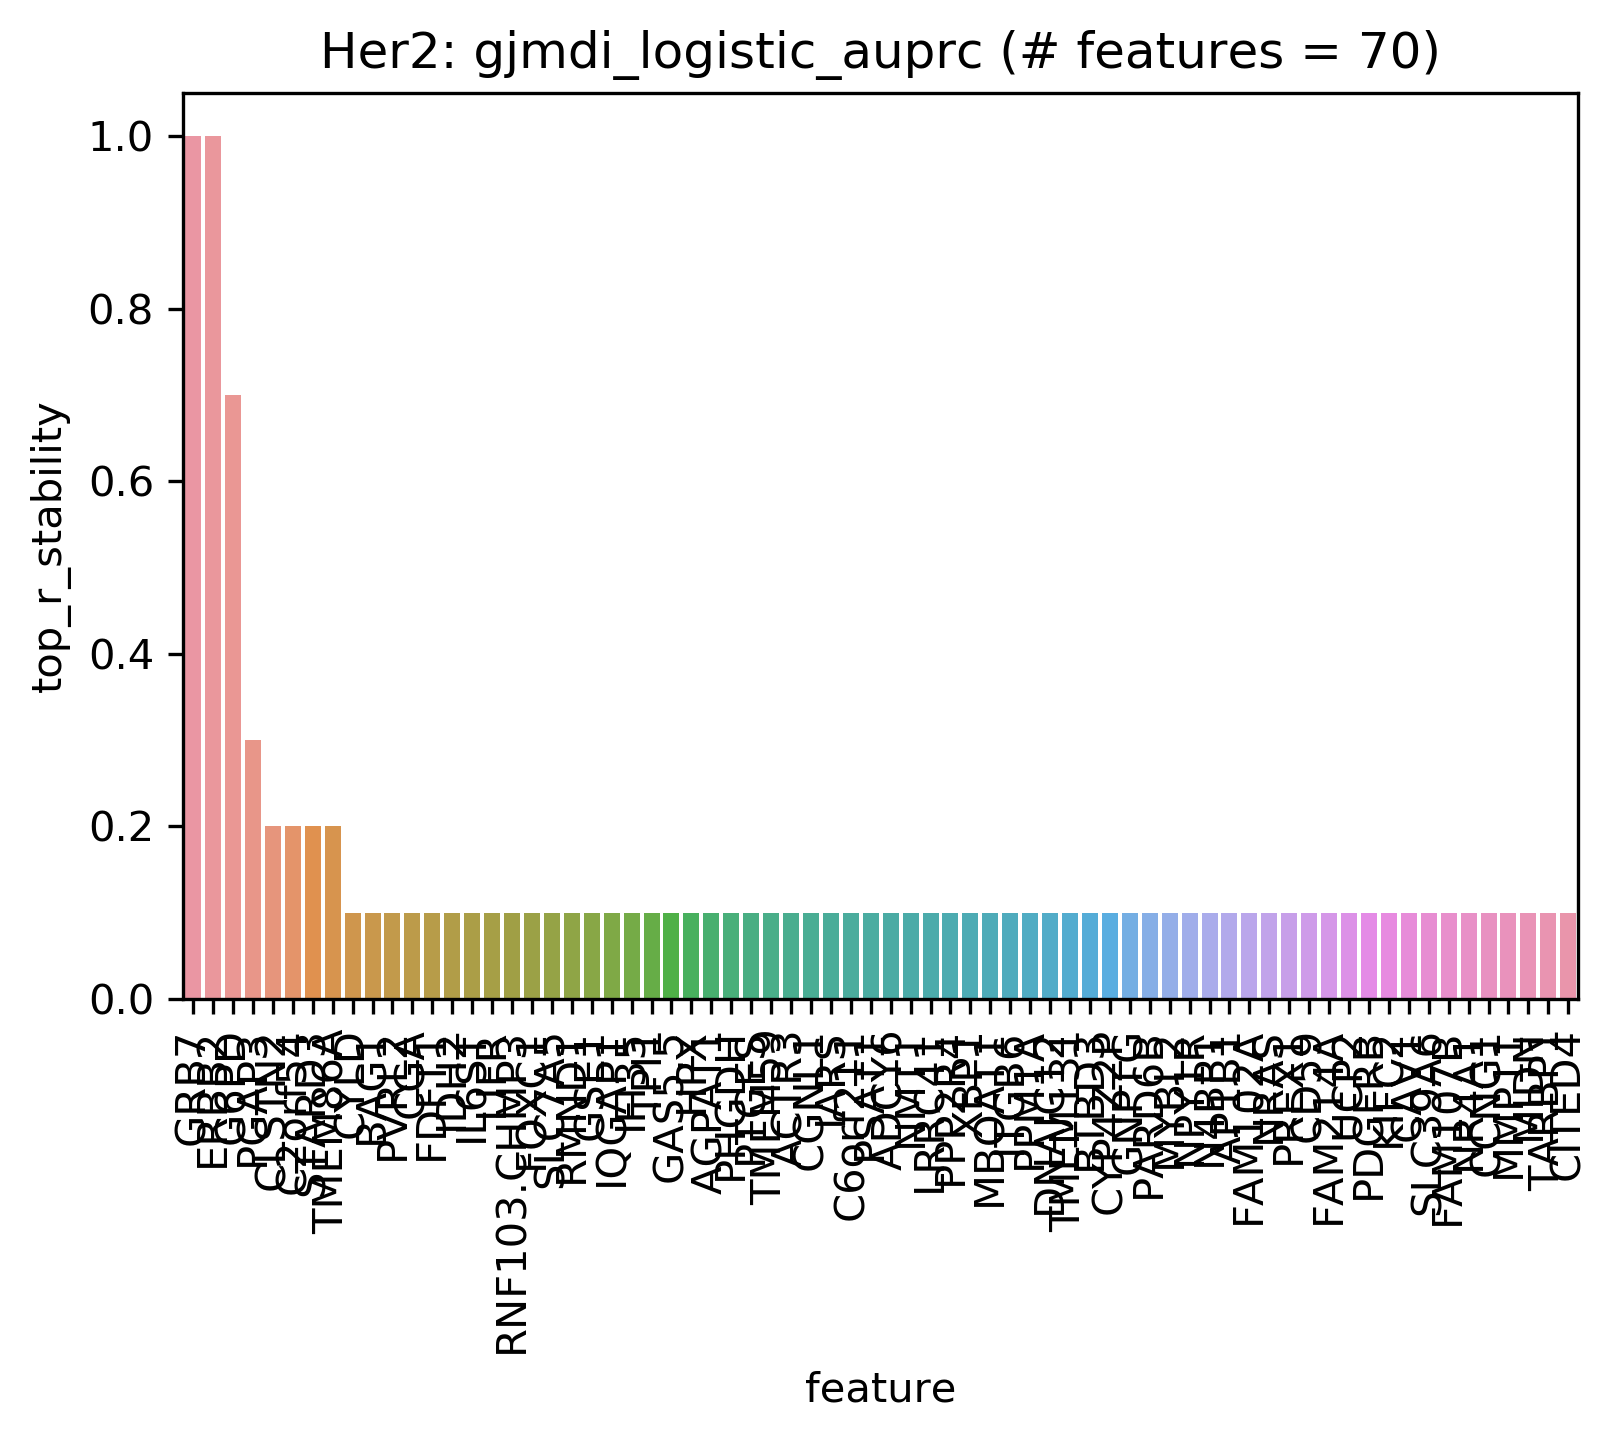

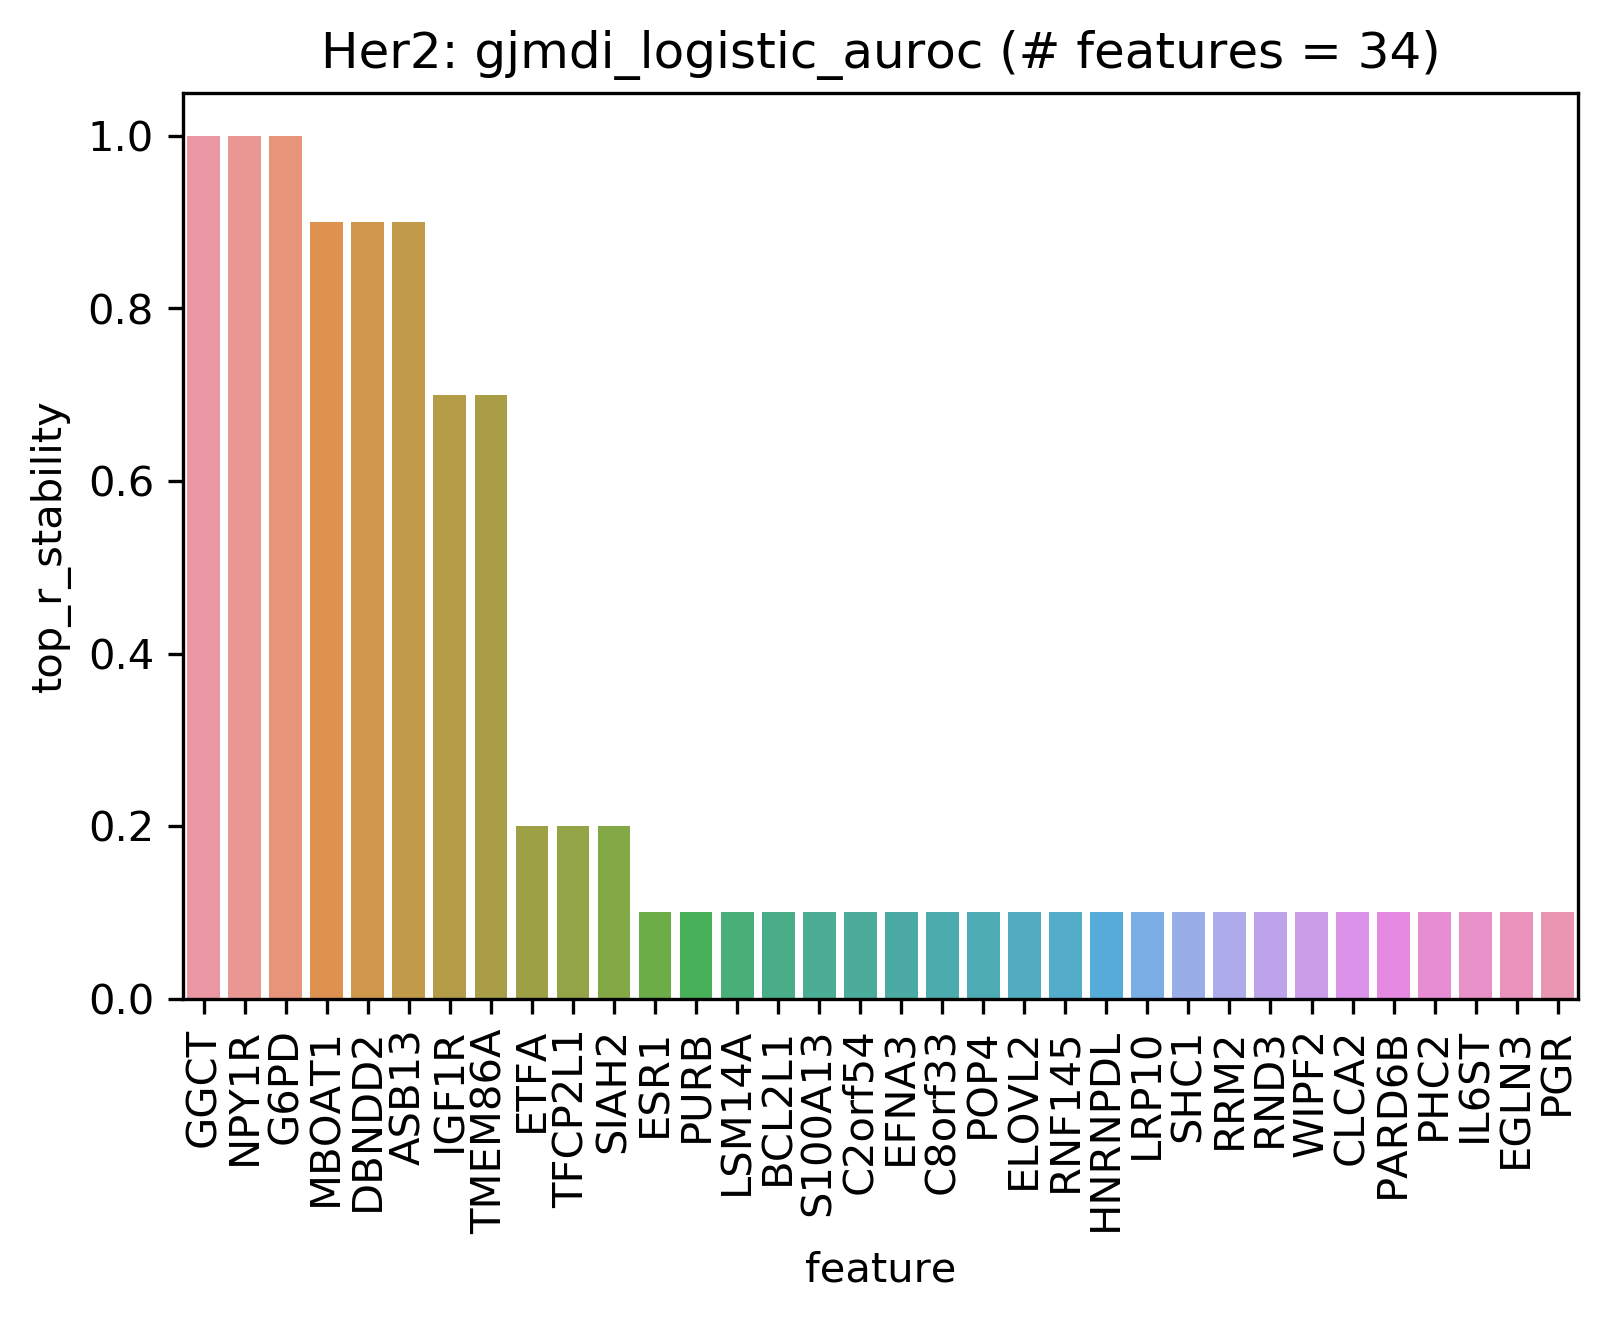

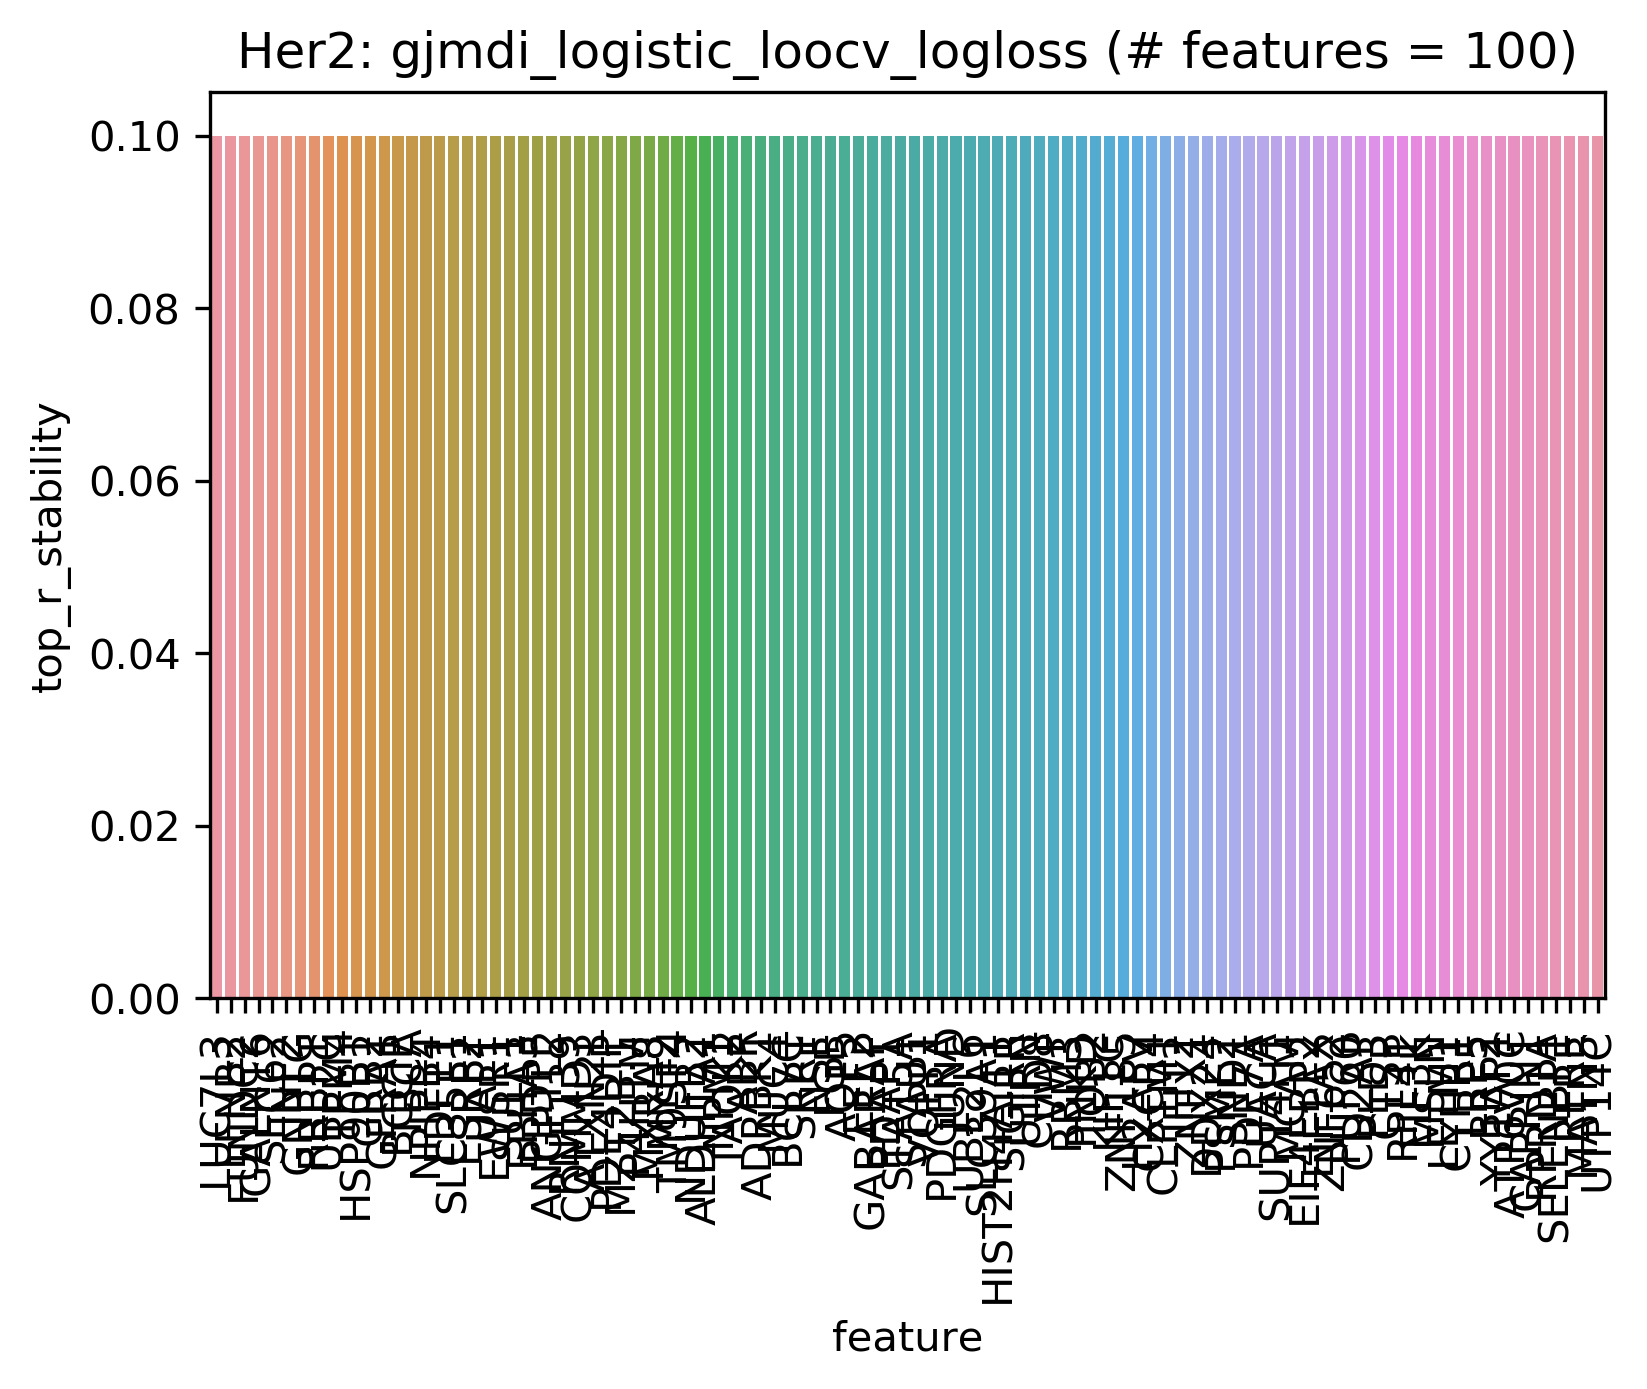

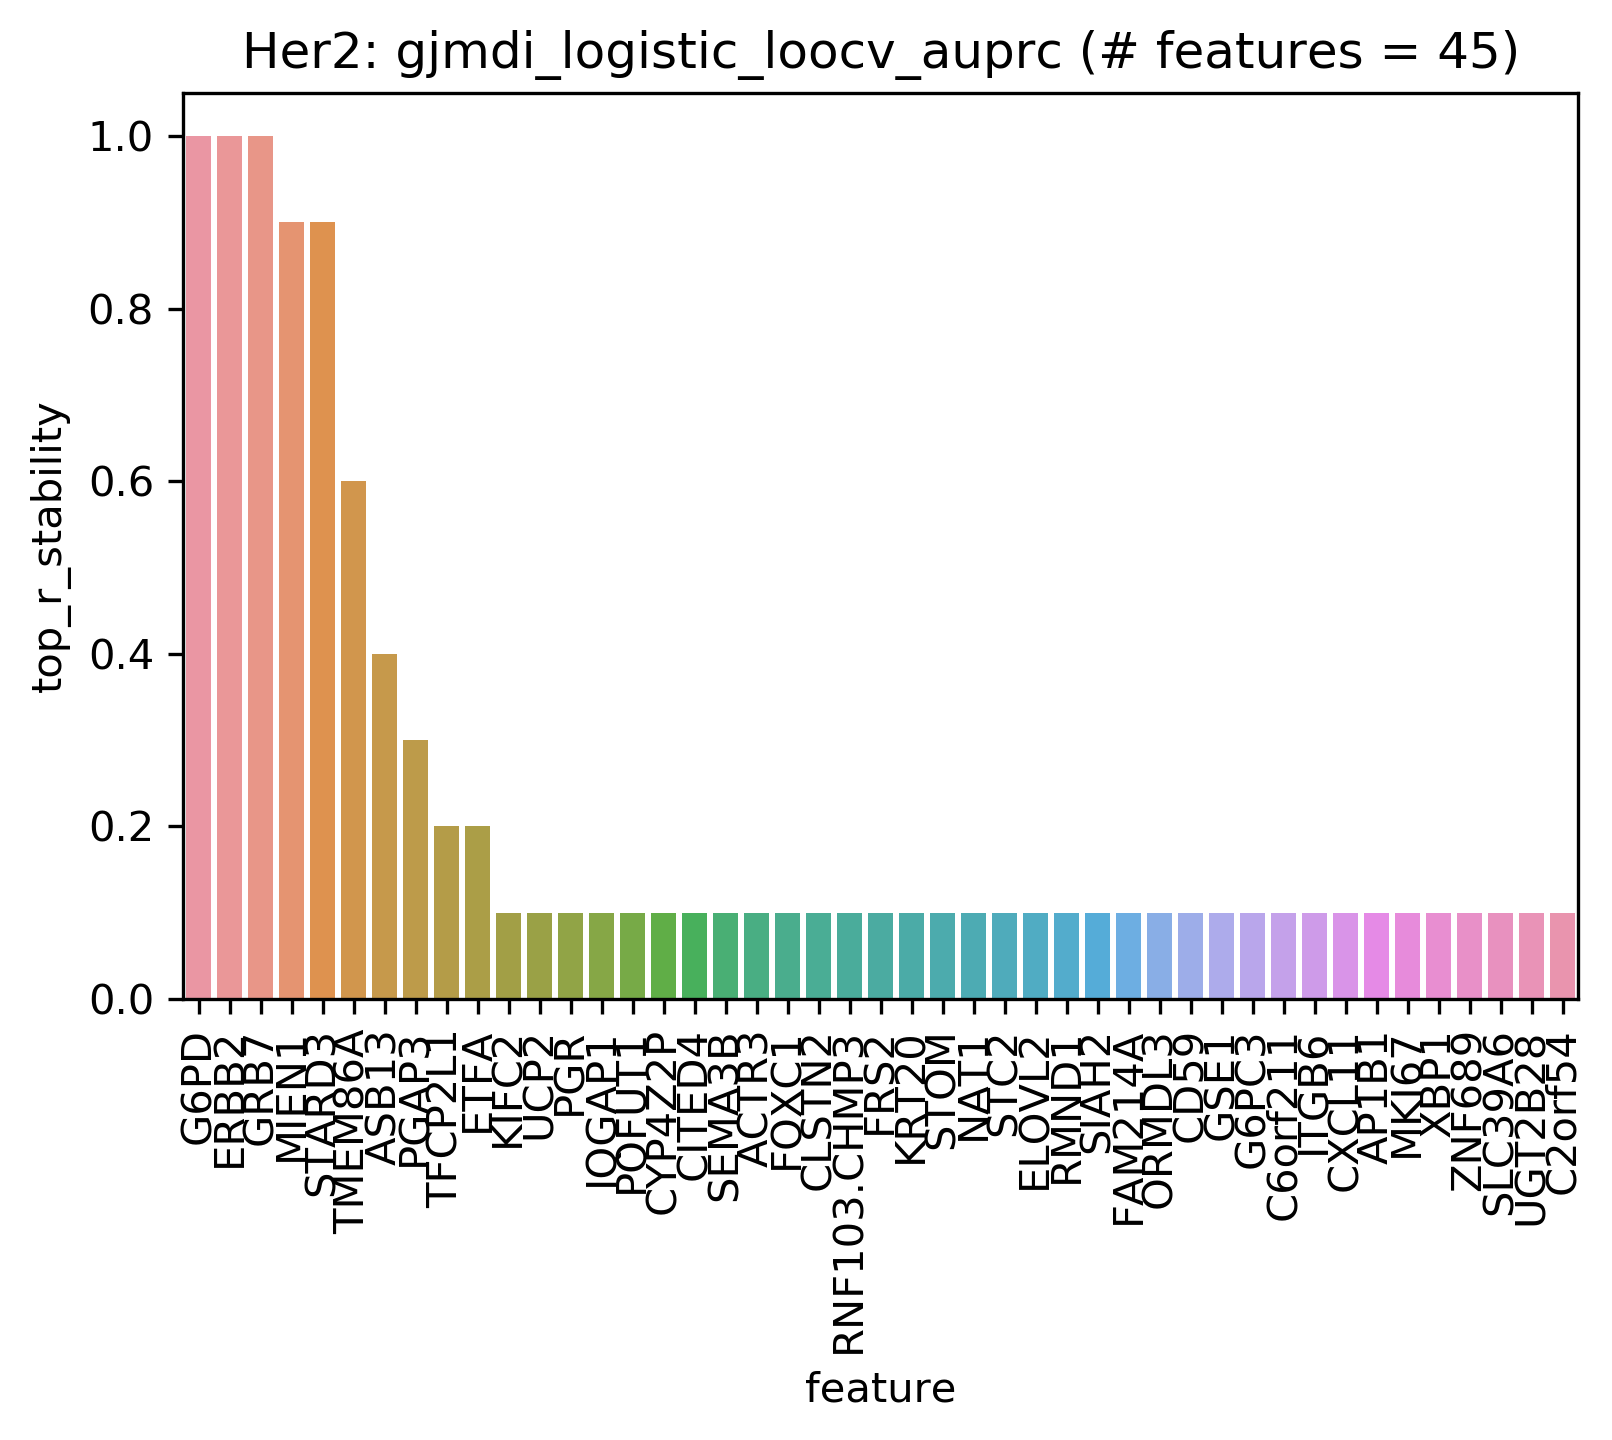

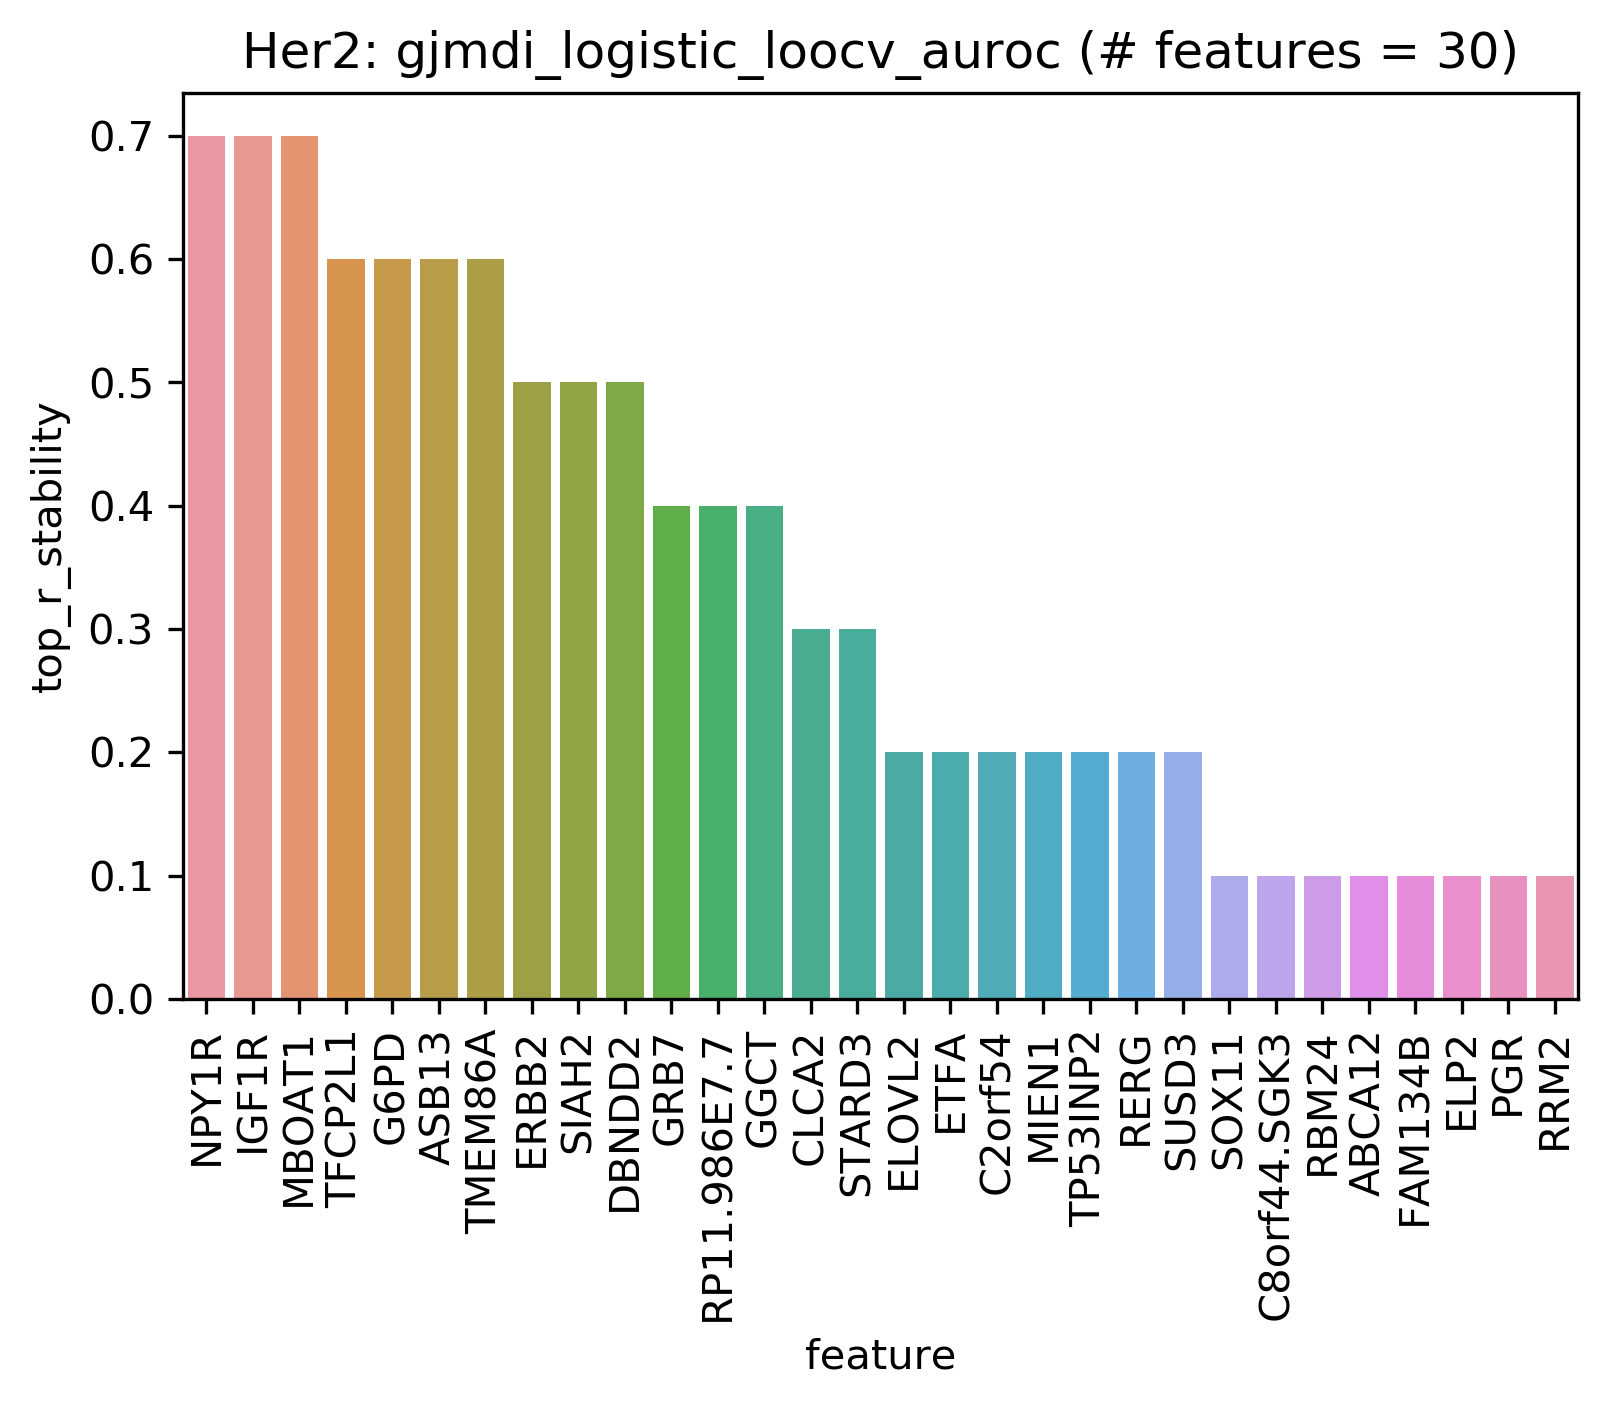

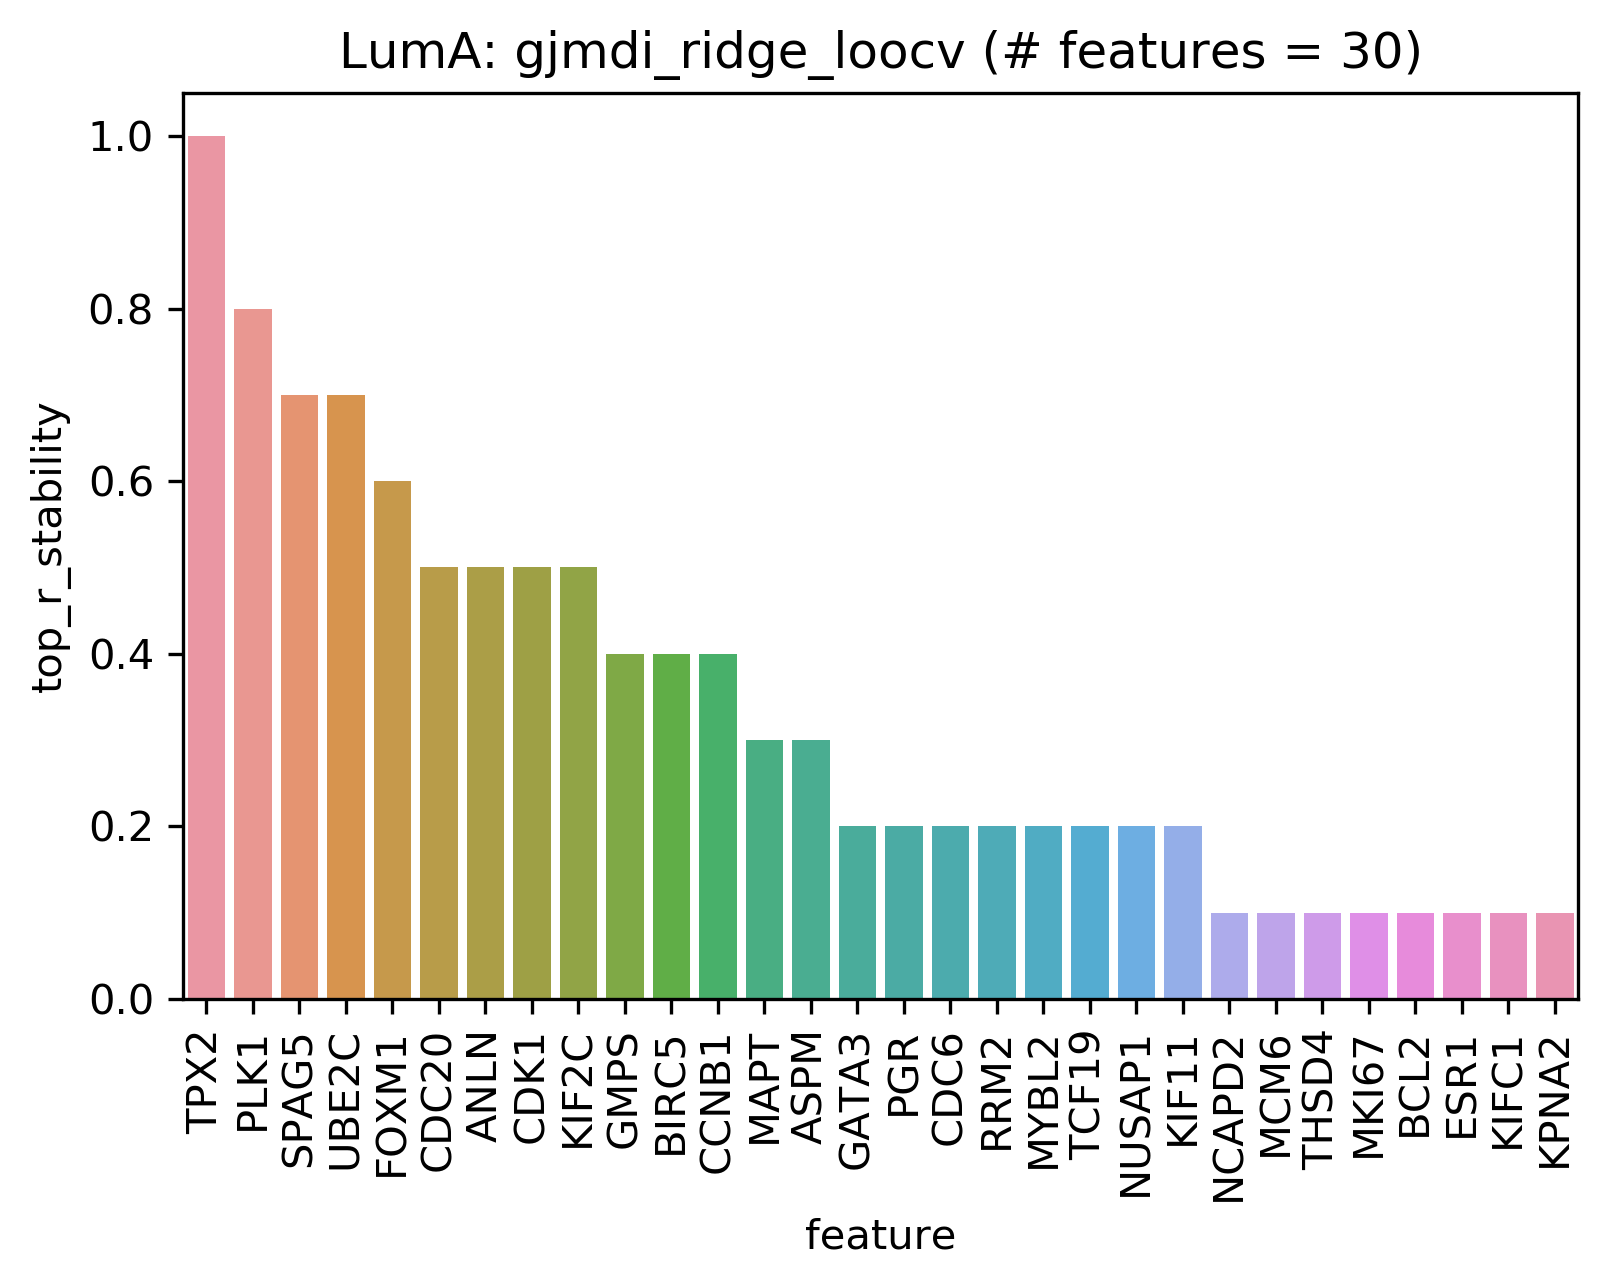

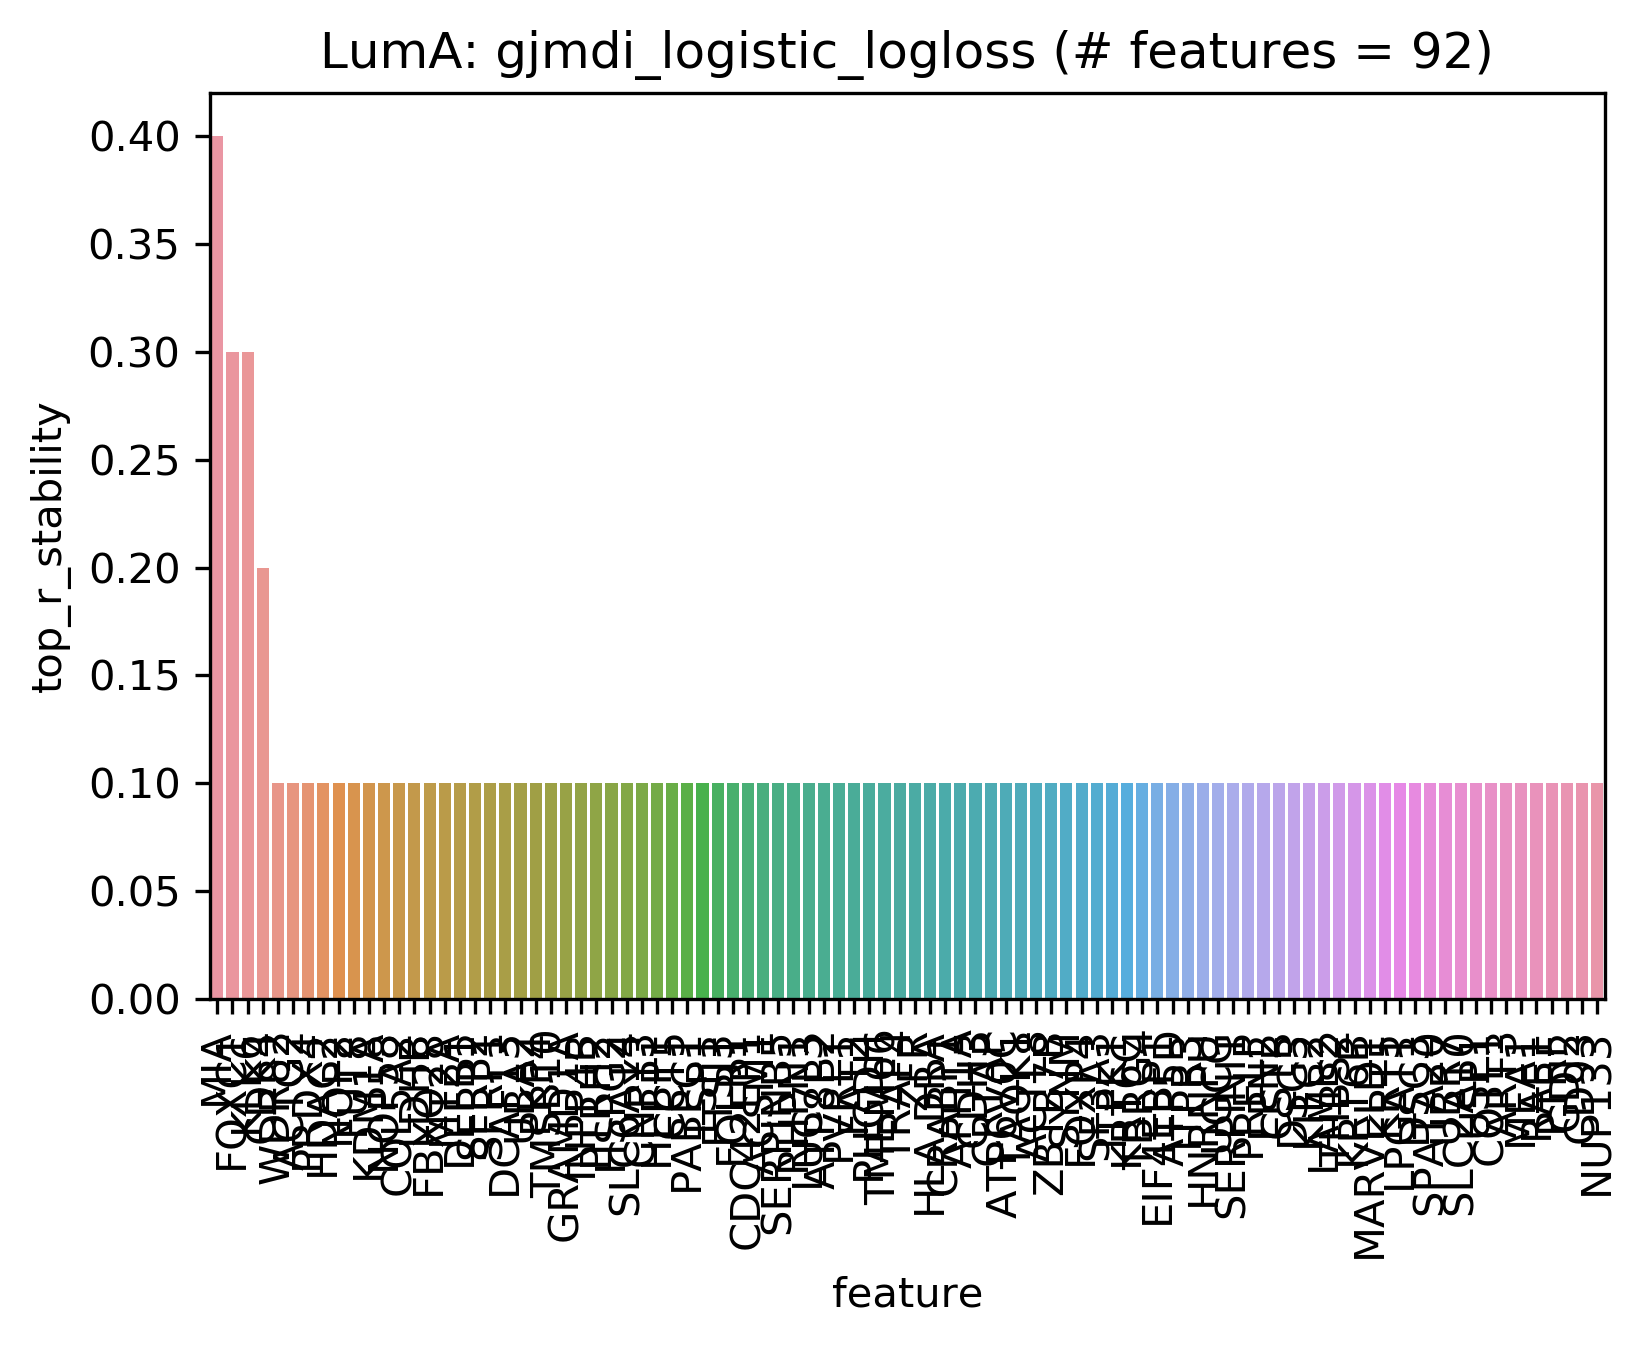

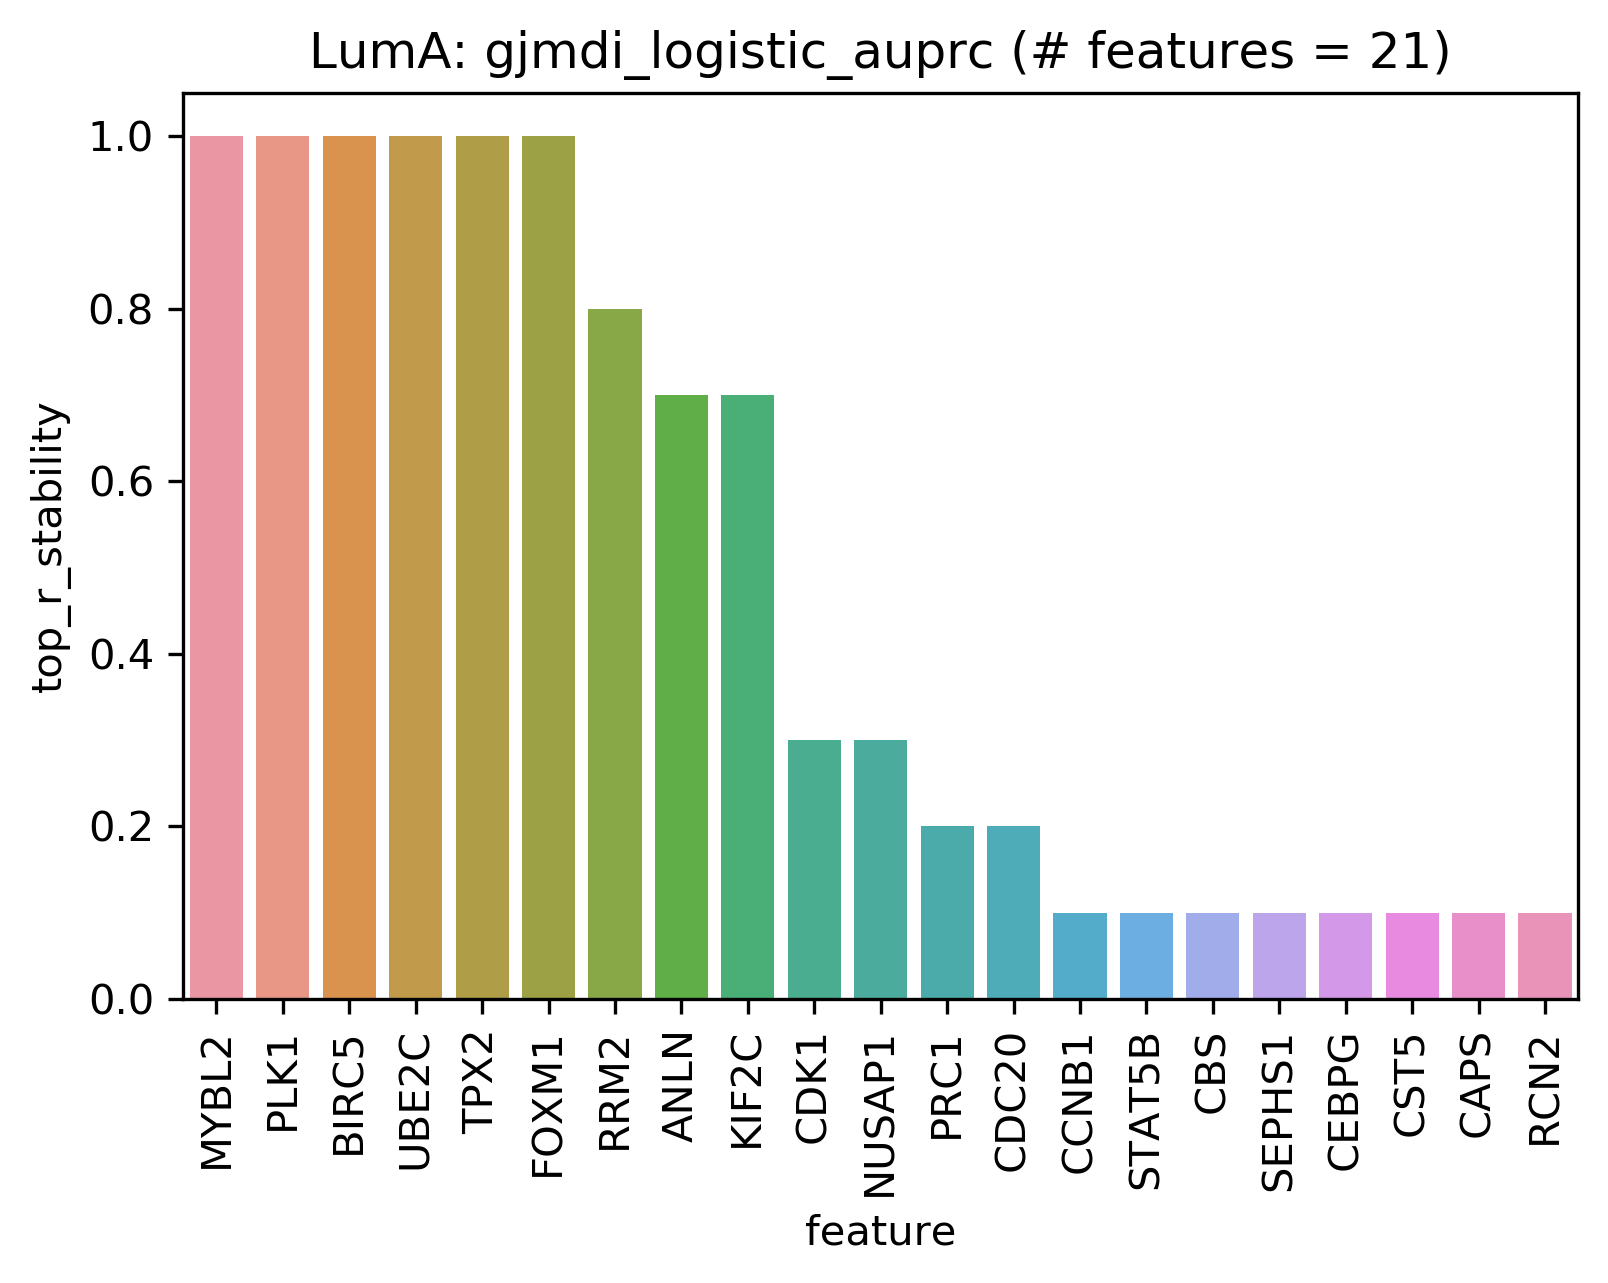

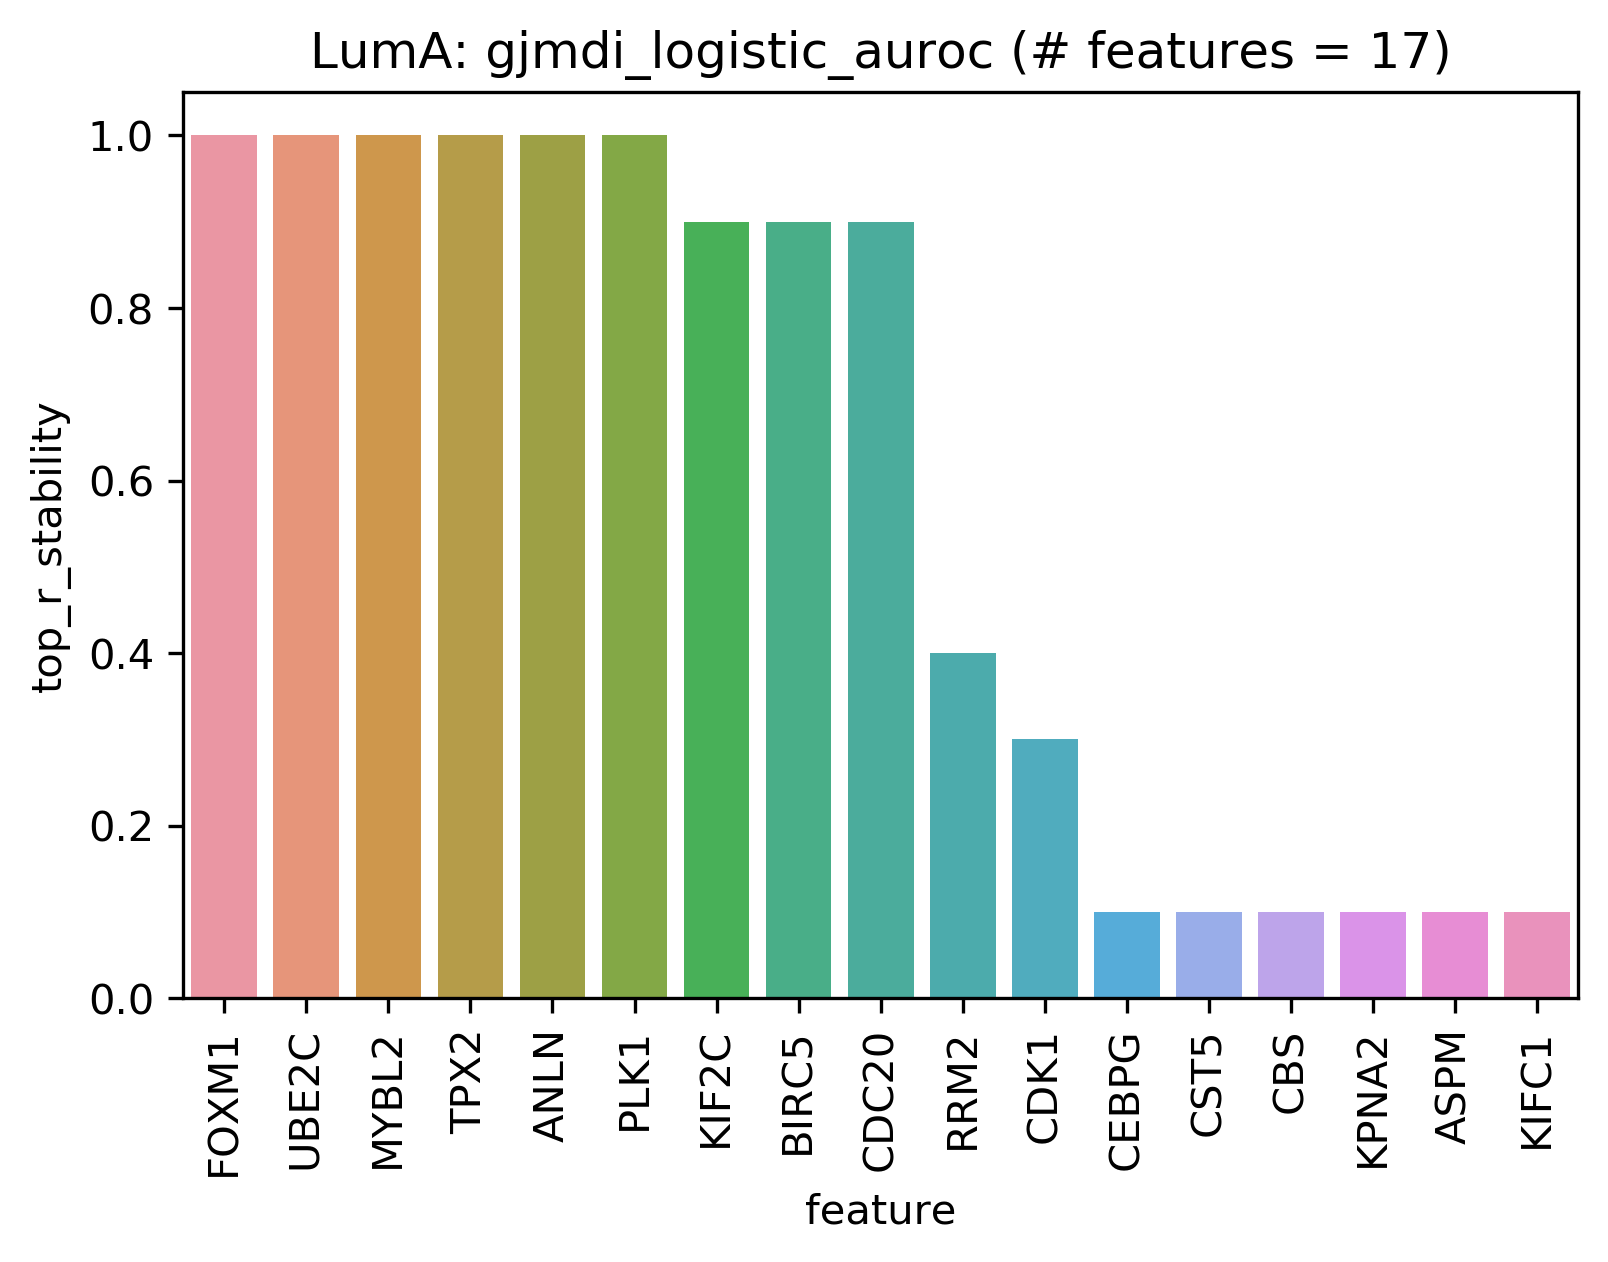

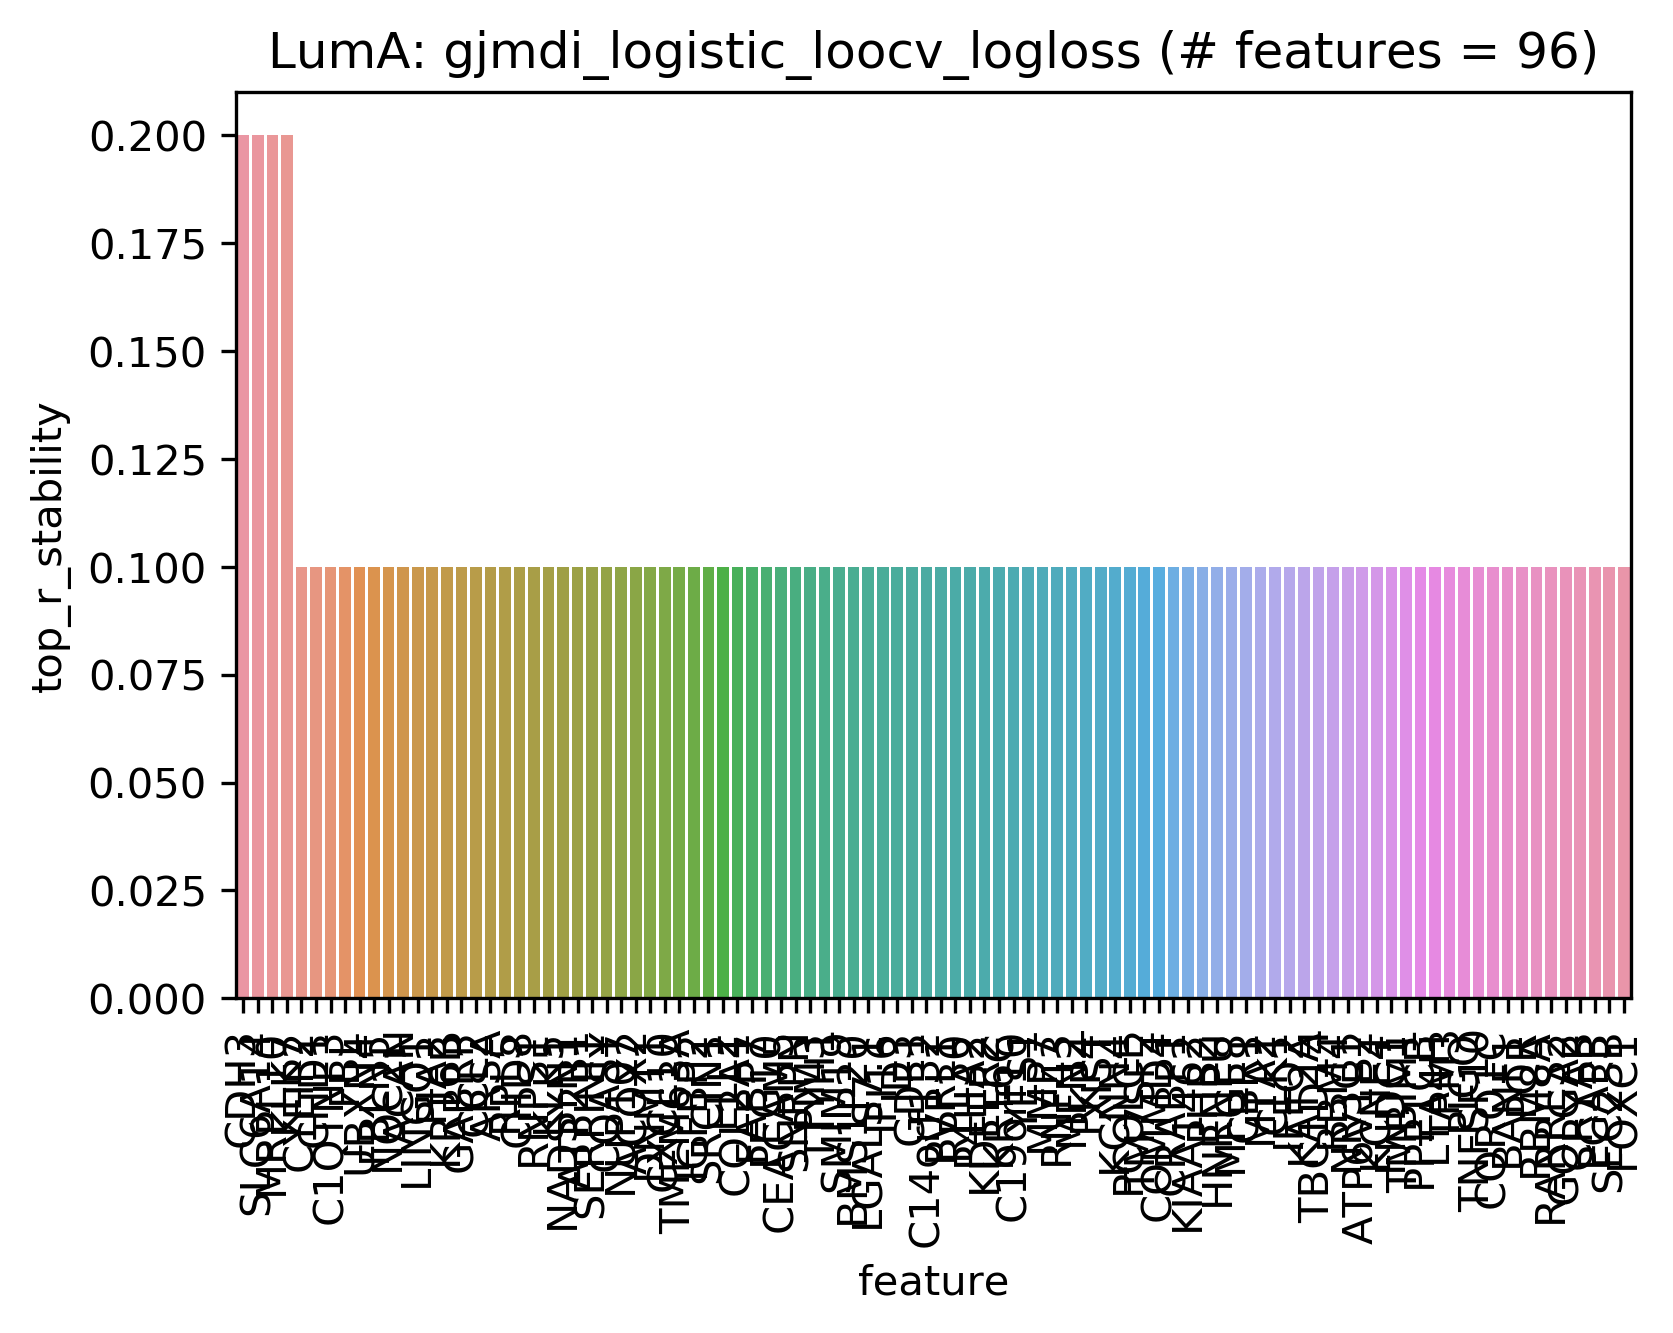

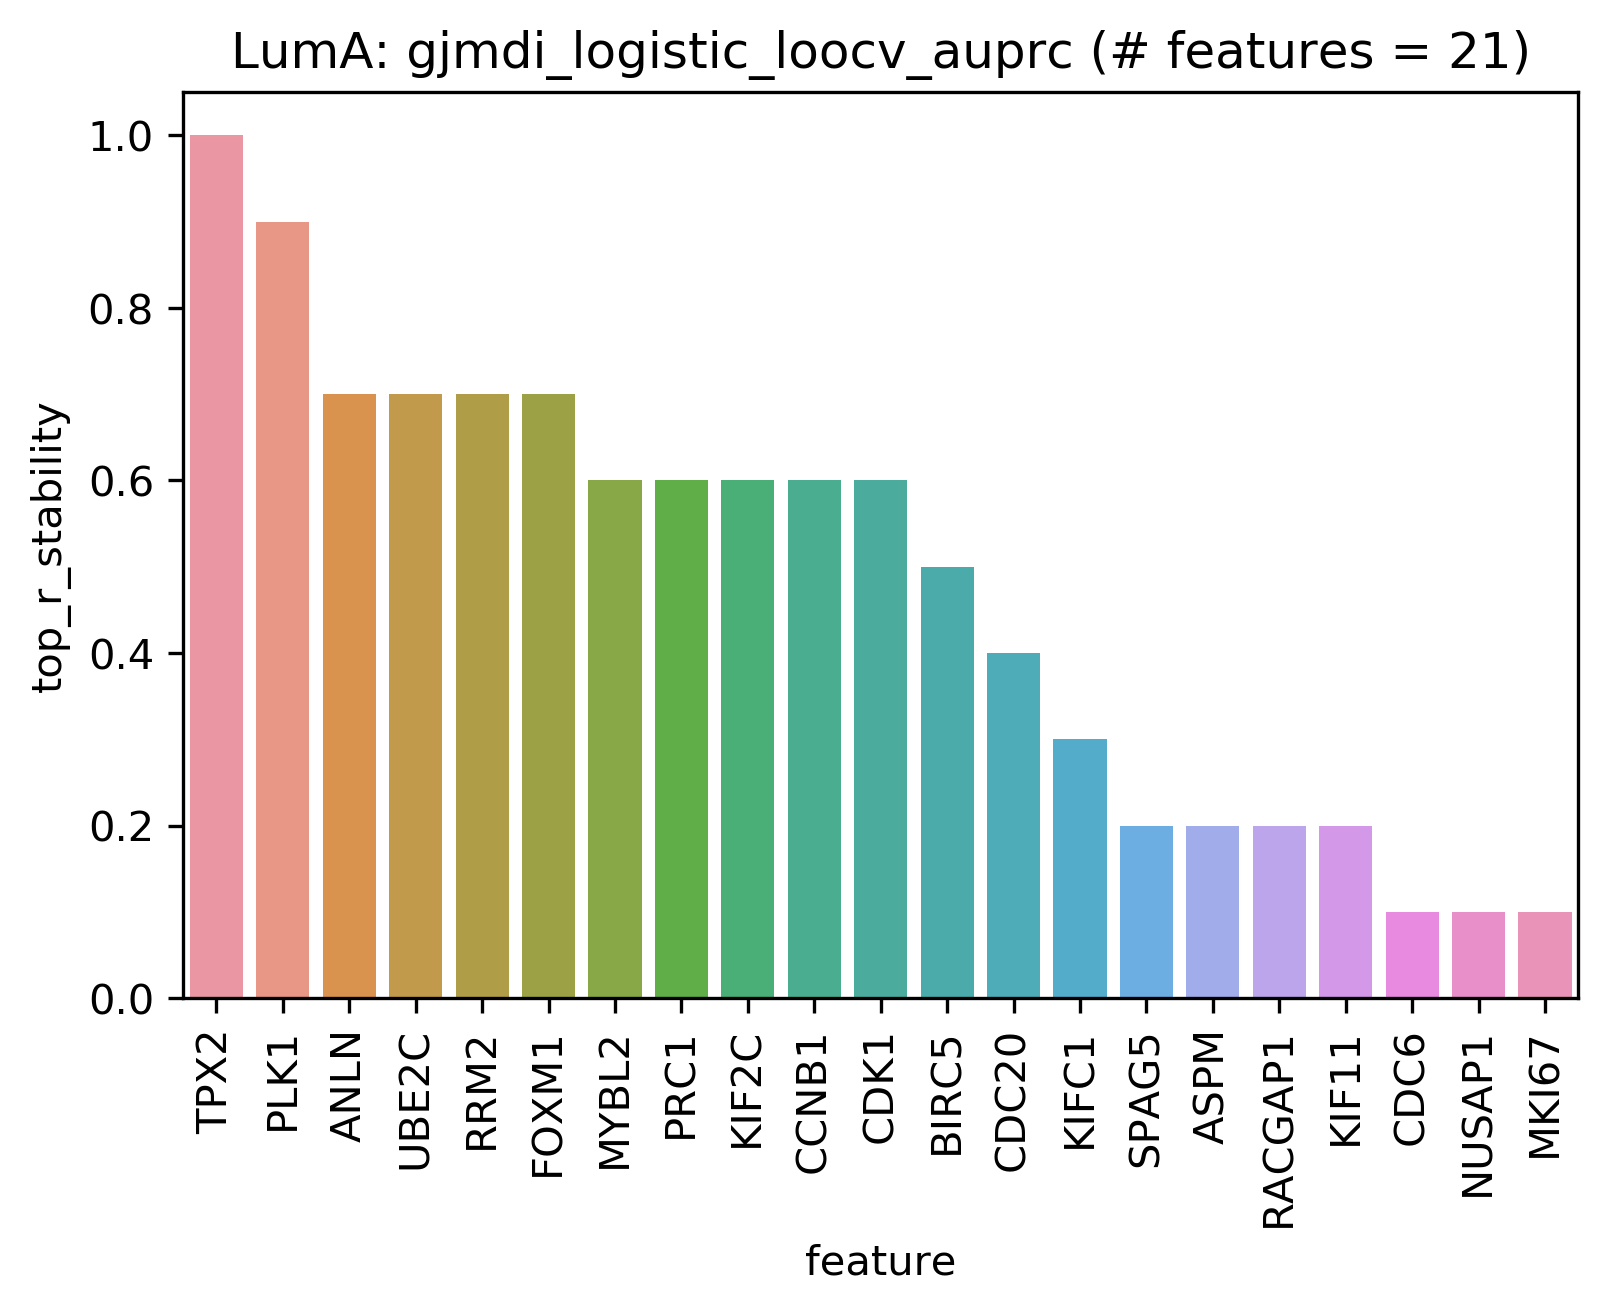

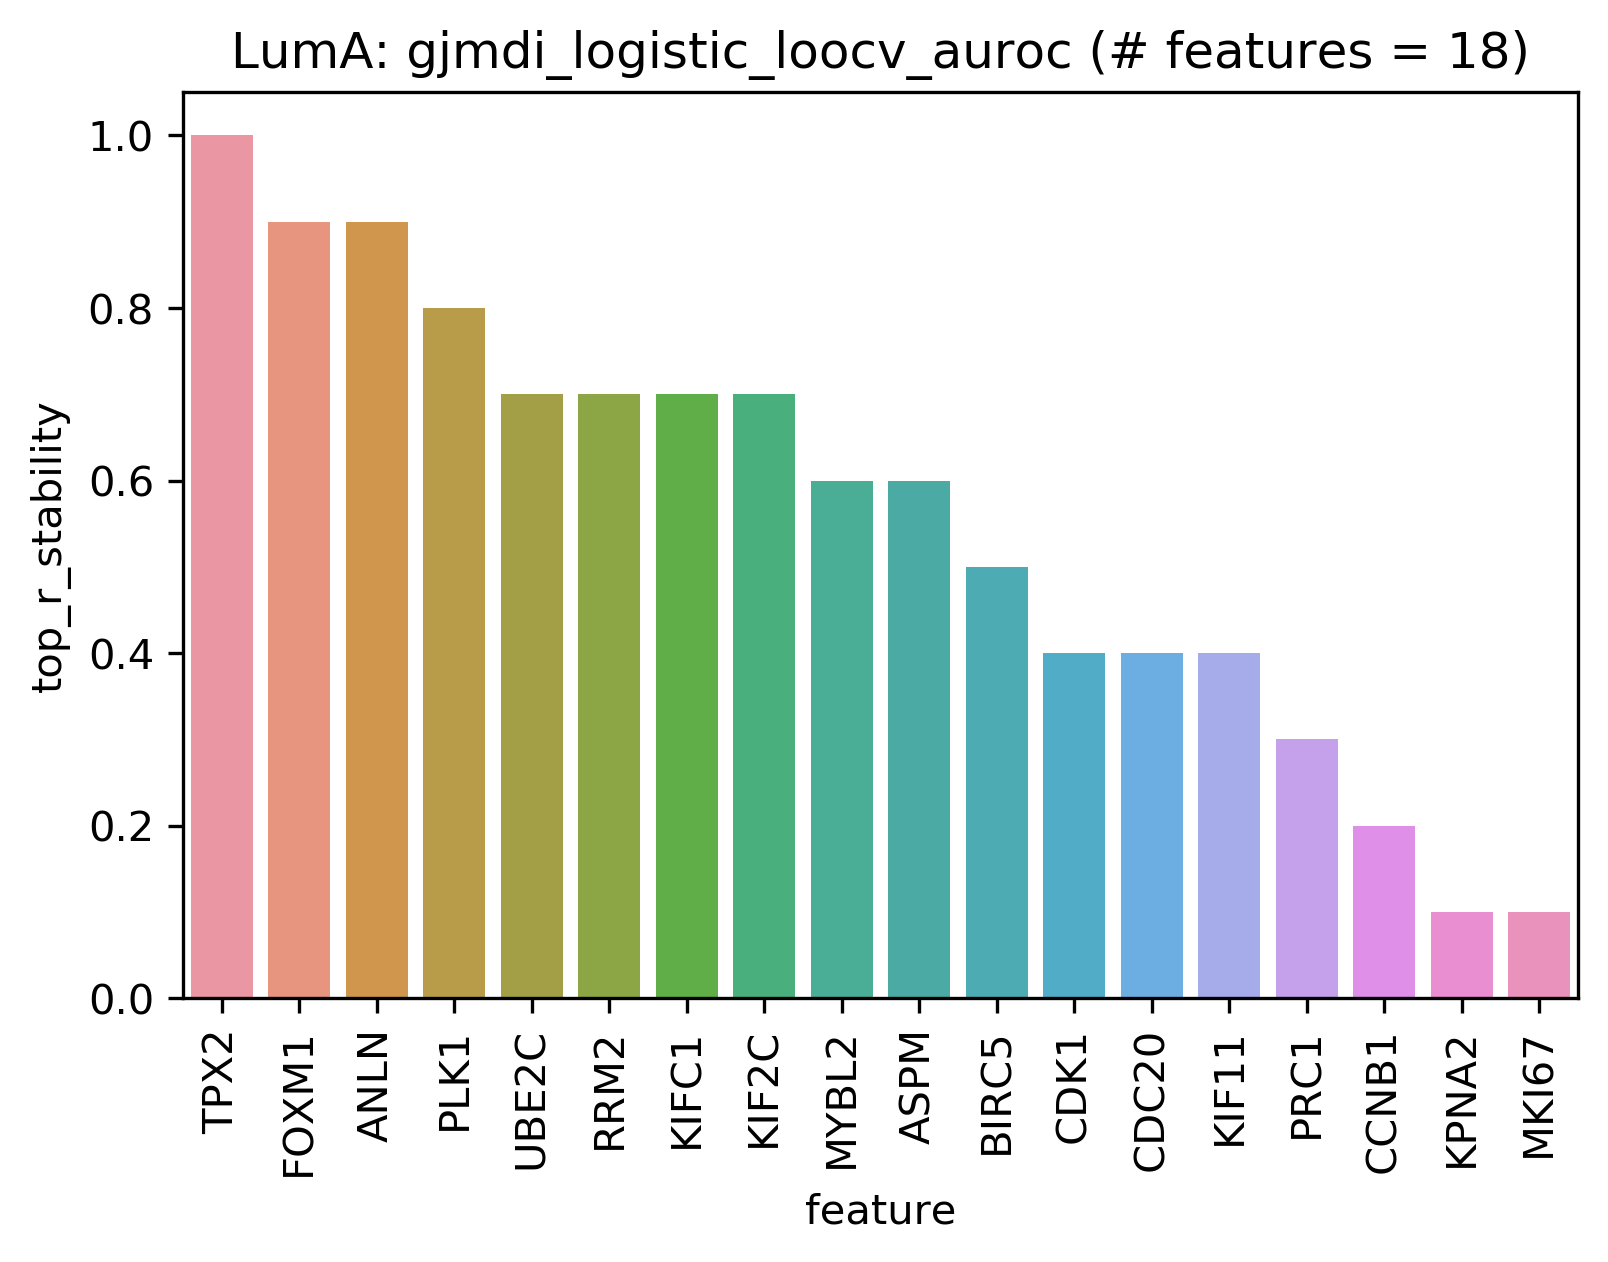

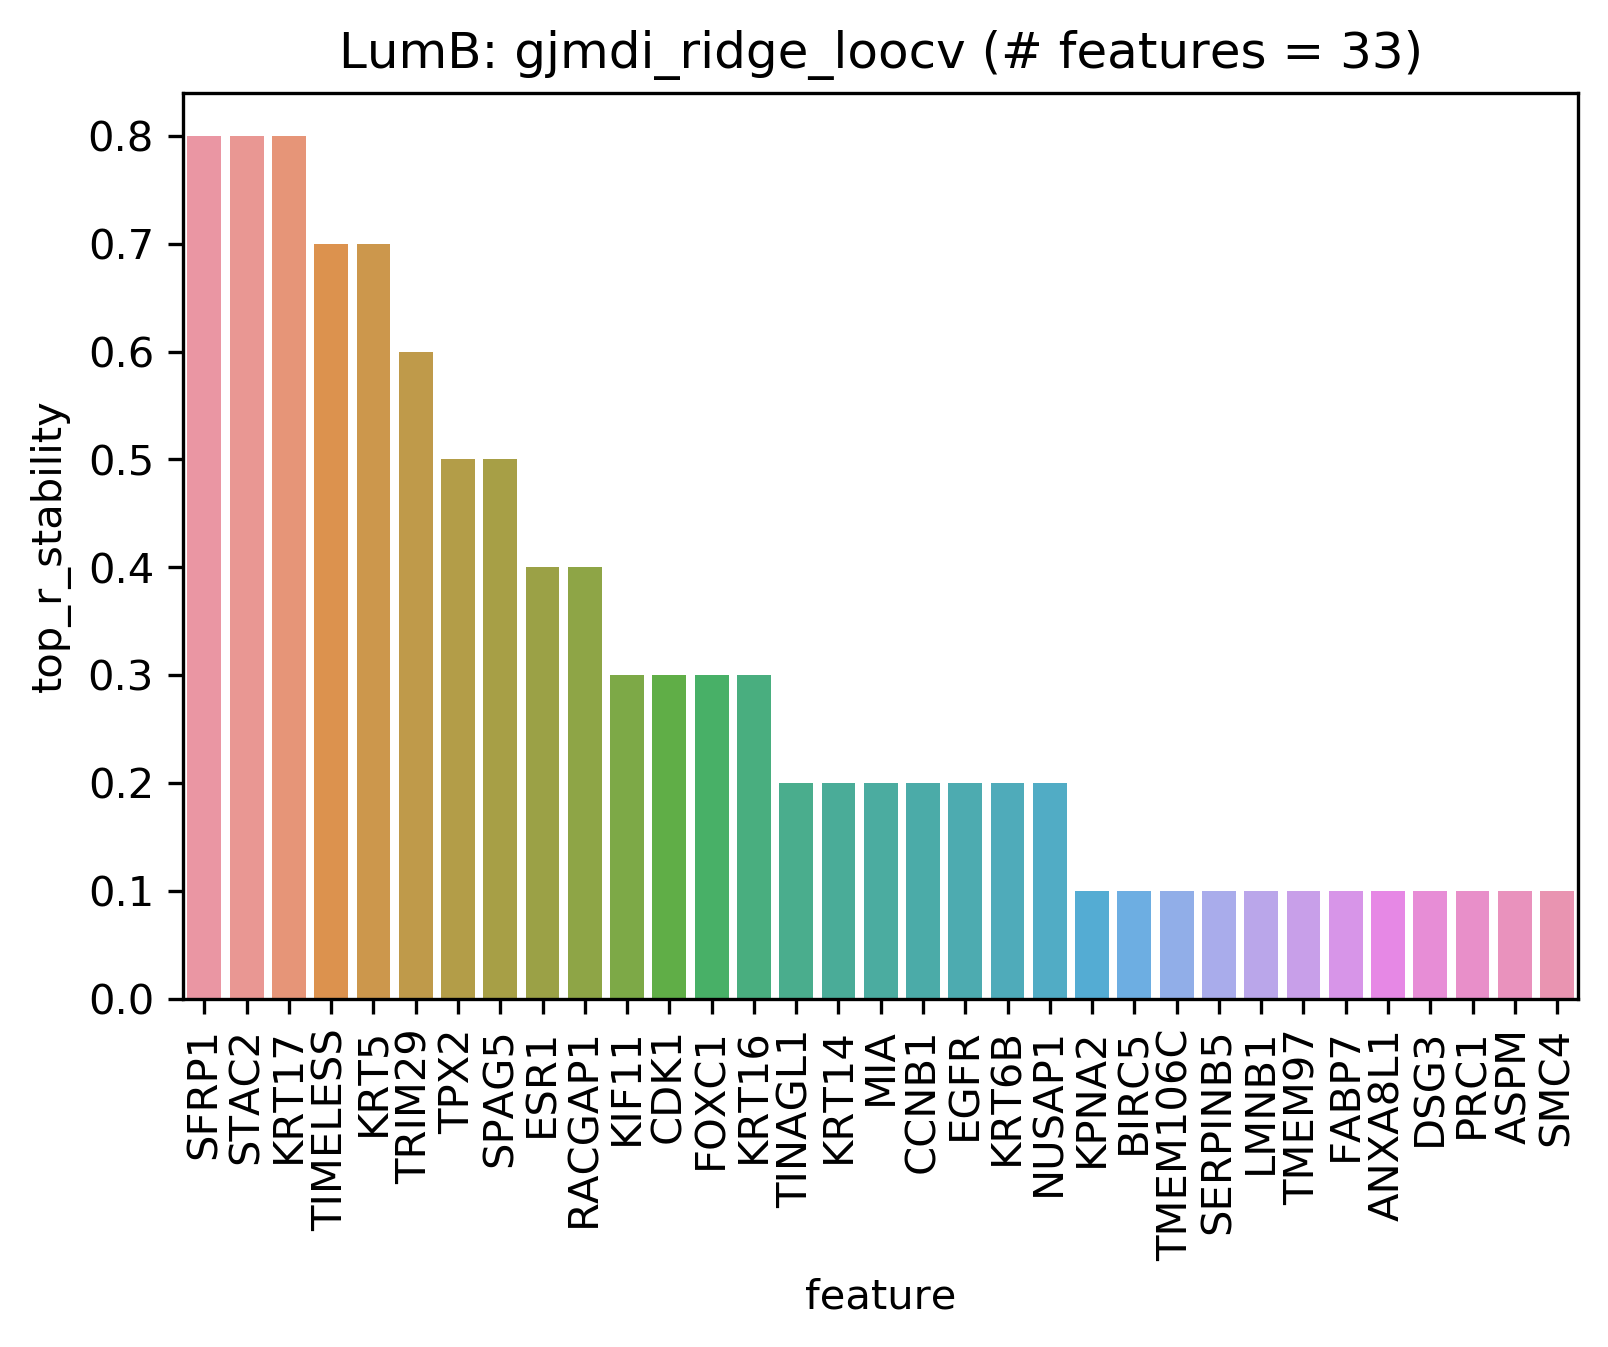

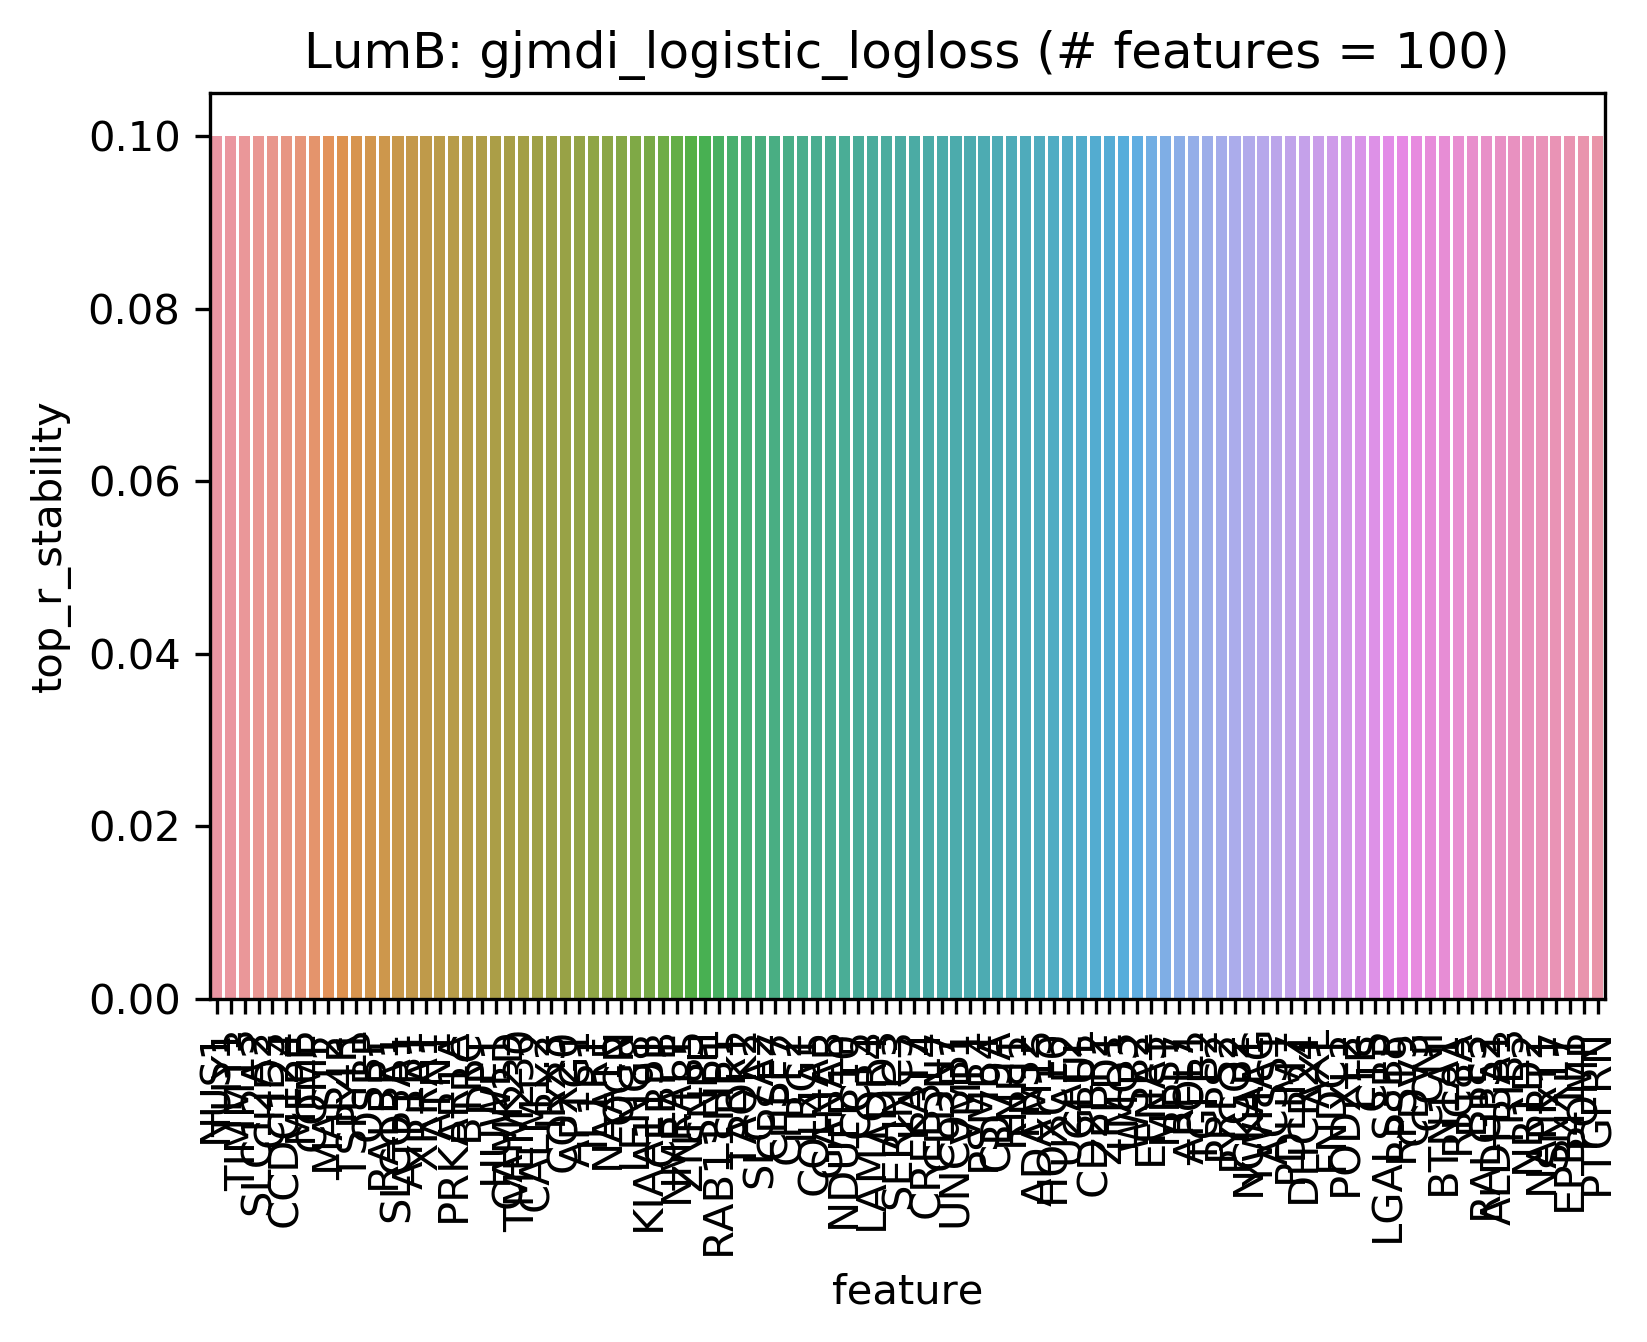

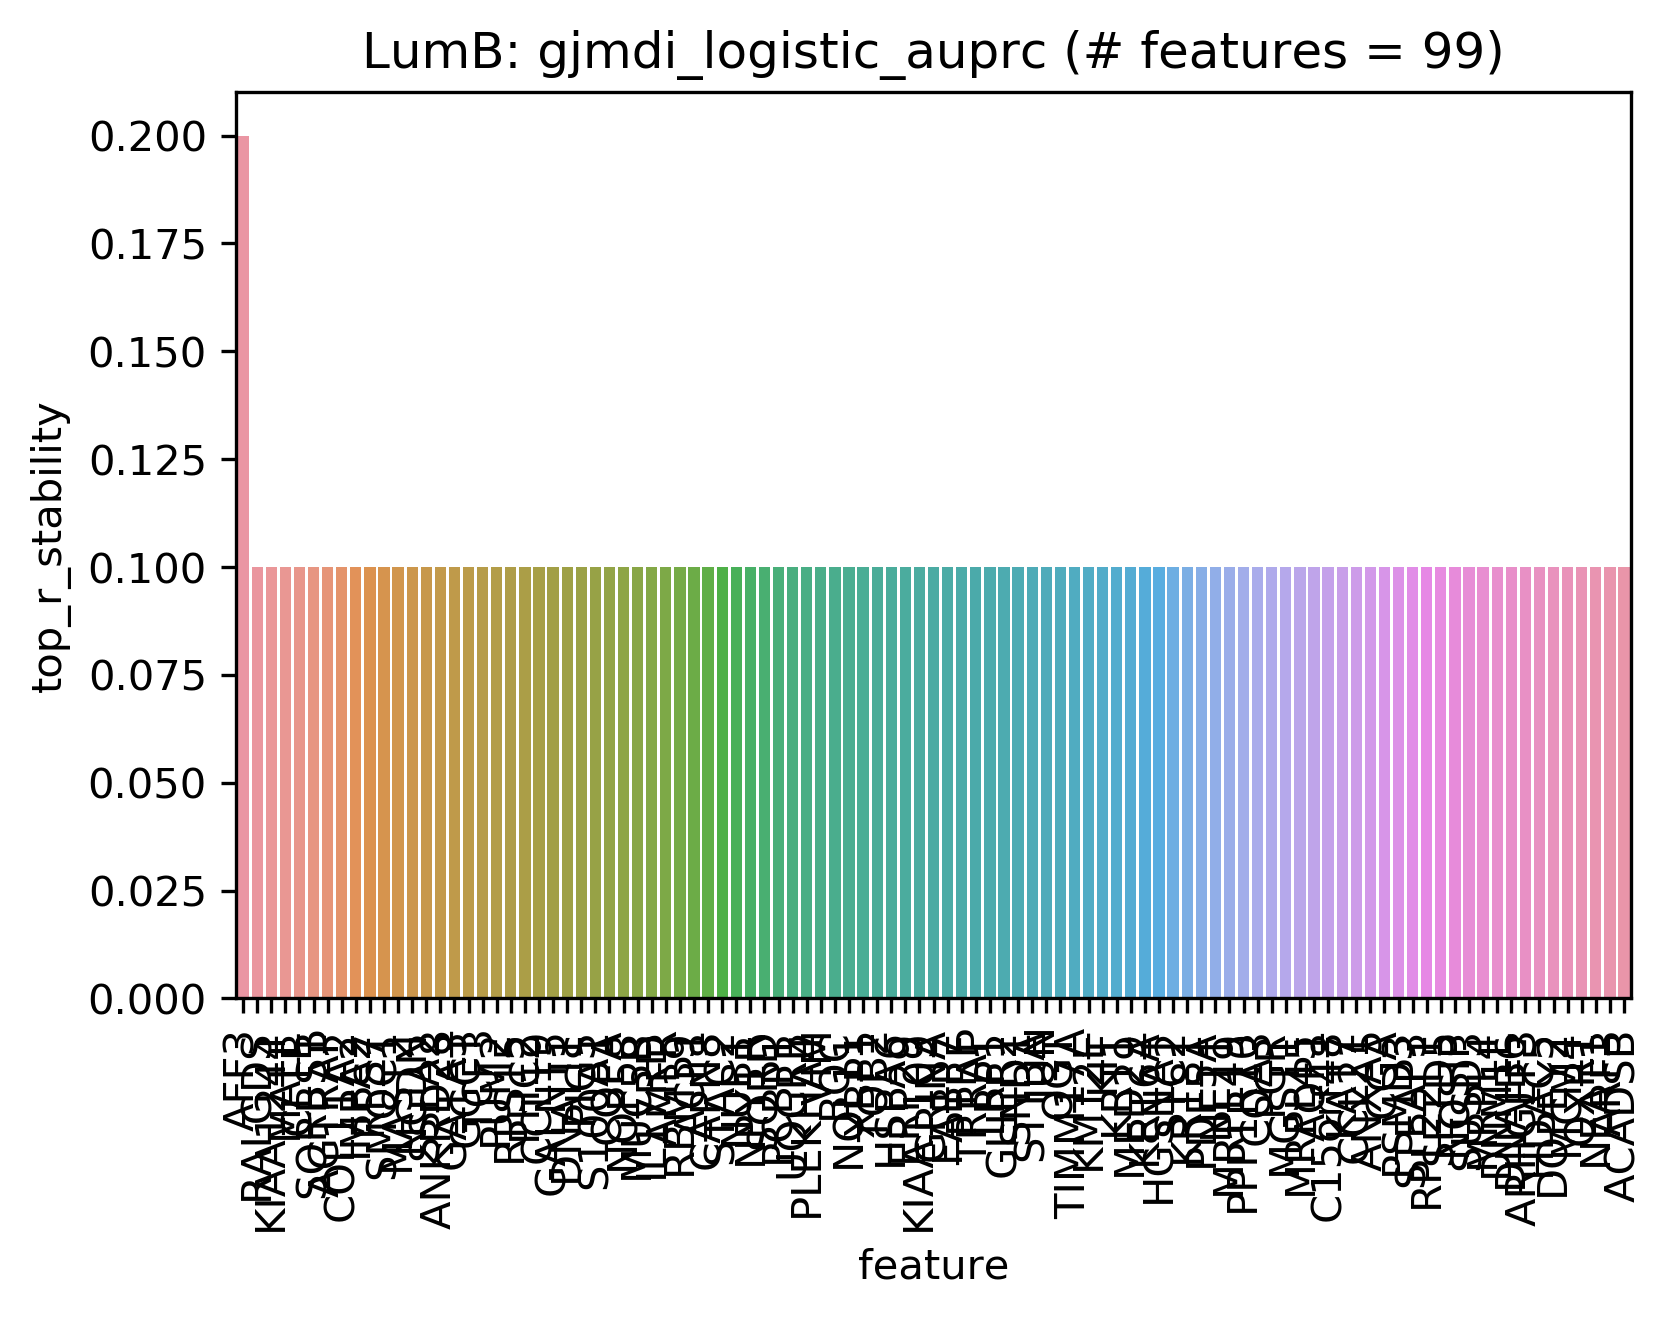

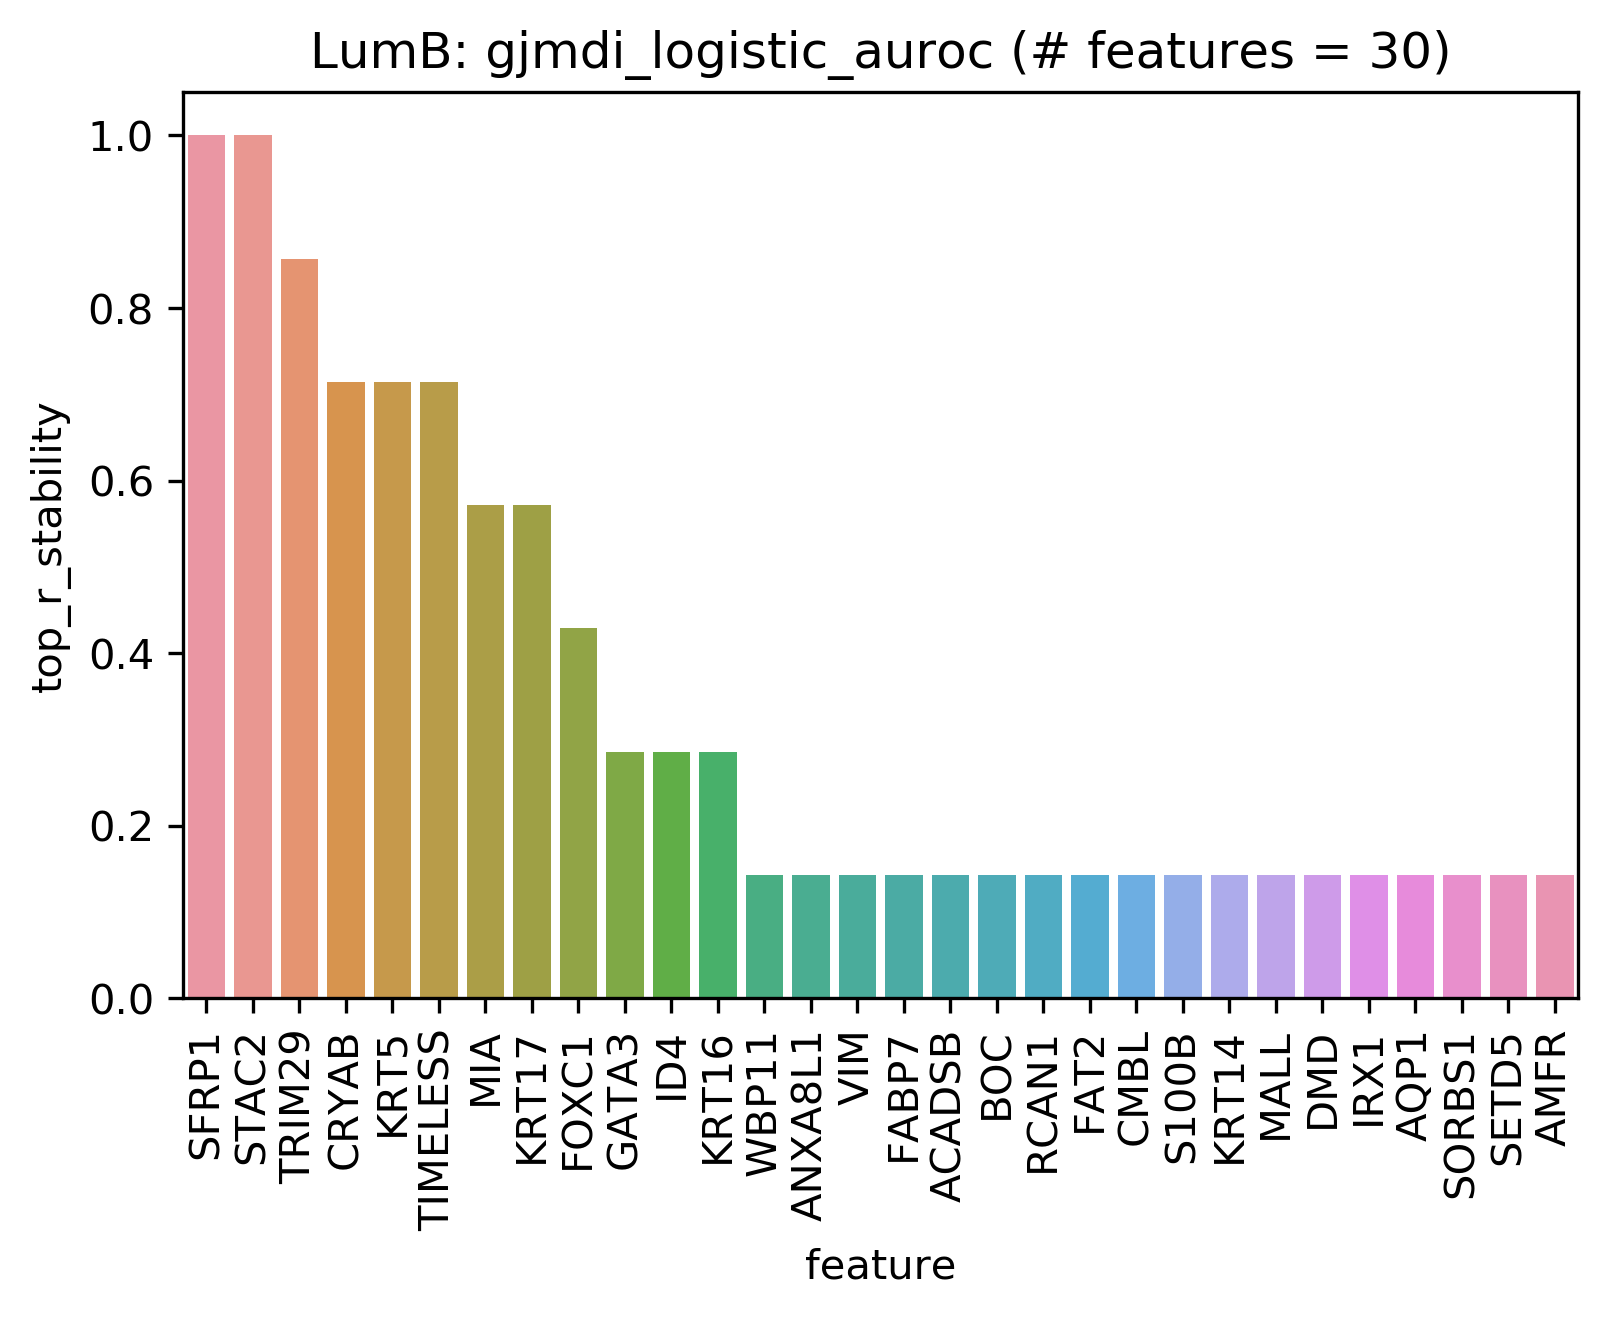

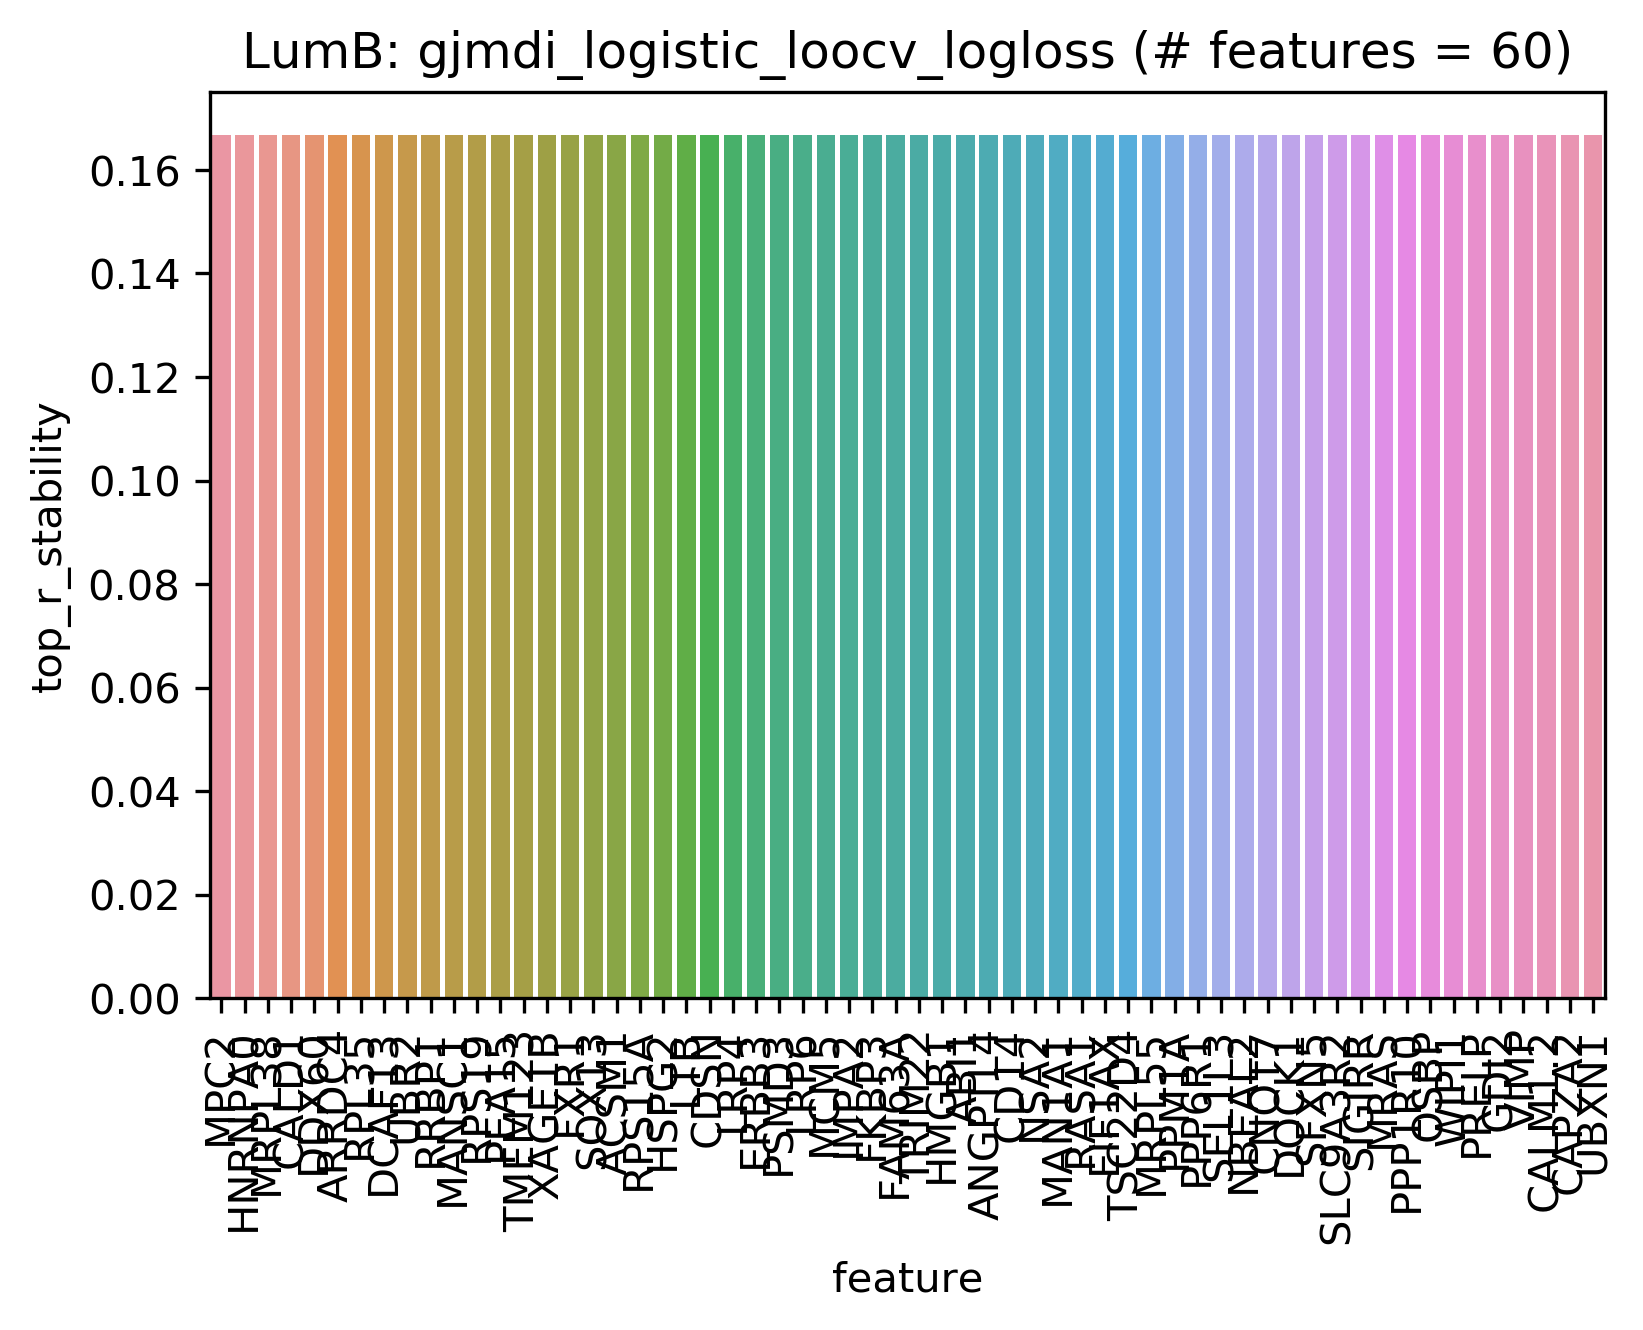

In [22]:
for subtype in stability_dict.keys():
    for method_name, df in stability_dict[subtype].items():
        df = df[df["top_r_stability"] > 0]
        ax = sns.barplot(
            x="feature", y="top_r_stability", data=df,
            order=df.sort_values("top_r_stability", ascending=False)["feature"]
        )
        ax.set_title("{}: {} (# features = {})".format(subtype, method_name, df.shape[0]))
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        plt.show()